In [1]:
import pandas as pd
import numpy as np
import torch, torch.nn
from transformers import BertModel, BertTokenizer, pipeline
import re, gc, os
import requests
from tqdm.auto import tqdm
import __init__

/z/home/sgal/miniconda3/envs/thermoPML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.BERTembeddings import BERTembeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer


path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ProtBERT.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ProtBERT.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ProtBERT.pth'


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BERT = BERTembeddings(type_embedding = "Rostlab/prot_bert", device = device)
Trainer = Trainer()

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
splits_meltome['sequence']=splits_meltome['sequence'].str.join(" ")
train, val, test = train_test_validation_splits(splits_meltome)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:

    batch_train, batch_test, batch_val = prepare_train_test_val_seqs_by_batches(train.sequence.to_list(), 
                                                                                test.sequence.to_list(), 
                                                                                val.sequence.to_list(), 
                                                                                batch_size=16)
    print ("Creating Embeddings...")   
    train_embeddings = BERT.embed_dataset(batch_train)
    torch.save(train_embeddings, path_train)
    test_embeddings = BERT.embed_dataset(batch_test)
    torch.save(test_embeddings, path_test)
    val_embeddings = BERT.embed_dataset(batch_val)
    torch.save(val_embeddings, path_val)
    print ("Loaded")
else:
    print ("Loading Premade Embeddings...")
    train_embeddings = torch.load(path_train)
    test_embeddings = torch.load(path_test)
    val_embeddings = torch.load(path_val)
    print ("Loaded")
    
train_loader = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy() ), batch_size=50)
test_loader = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy() ), batch_size=50)
val_loader = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy() ), batch_size=50)

Creating Embeddings...


  0%|          | 0/1396 [00:00<?, ?it/s]

/z/home/sgal/miniconda3/envs/thermoPML/lib/python3.9/site-packages/optimum/bettertransformer/models/encoder_models.py:247: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  hidden_states = torch._nested_tensor_from_mask(hidden_states, ~attention_mask)


  0%|          | 1/1396 [00:08<3:27:01,  8.90s/it]

  0%|          | 2/1396 [00:09<1:30:24,  3.89s/it]

  0%|          | 3/1396 [00:09<51:28,  2.22s/it]  

  0%|          | 4/1396 [00:09<34:06,  1.47s/it]

  0%|          | 5/1396 [00:10<25:27,  1.10s/it]

  0%|          | 6/1396 [00:10<19:17,  1.20it/s]

  1%|          | 7/1396 [00:10<13:48,  1.68it/s]

  1%|          | 8/1396 [00:10<11:21,  2.04it/s]

  1%|          | 9/1396 [00:11<10:12,  2.27it/s]

  1%|          | 10/1396 [00:11<09:38,  2.40it/s]

  1%|          | 11/1396 [00:11<08:38,  2.67it/s]

  1%|          | 12/1396 [00:12<07:59,  2.88it/s]

  1%|          | 13/1396 [00:12<08:10,  2.82it/s]

  1%|          | 14/1396 [00:12<08:15,  2.79it/s]

  1%|          | 15/1396 [00:13<08:17,  2.77it/s]

  1%|          | 16/1396 [00:13<07:11,  3.20it/s]

  1%|          | 17/1396 [00:13<07:09,  3.21it/s]

  1%|▏         | 18/1396 [00:14<07:01,  3.27it/s]

  1%|▏         | 19/1396 [00:14<07:07,  3.22it/s]

  1%|▏         | 20/1396 [00:14<06:53,  3.33it/s]

  2%|▏         | 21/1396 [00:14<06:26,  3.56it/s]

  2%|▏         | 22/1396 [00:15<06:20,  3.61it/s]

  2%|▏         | 23/1396 [00:15<07:44,  2.96it/s]

  2%|▏         | 24/1396 [00:16<07:59,  2.86it/s]

  2%|▏         | 25/1396 [00:16<08:30,  2.68it/s]

  2%|▏         | 26/1396 [00:16<08:05,  2.82it/s]

  2%|▏         | 27/1396 [00:17<07:44,  2.95it/s]

  2%|▏         | 28/1396 [00:17<07:50,  2.91it/s]

  2%|▏         | 29/1396 [00:17<08:30,  2.68it/s]

  2%|▏         | 30/1396 [00:18<08:23,  2.71it/s]

  2%|▏         | 31/1396 [00:18<07:53,  2.88it/s]

  2%|▏         | 32/1396 [00:18<07:38,  2.98it/s]

  2%|▏         | 33/1396 [00:19<08:25,  2.70it/s]

  2%|▏         | 34/1396 [00:19<07:49,  2.90it/s]

  3%|▎         | 35/1396 [00:19<07:29,  3.03it/s]

  3%|▎         | 36/1396 [00:20<07:05,  3.19it/s]

  3%|▎         | 37/1396 [00:20<05:55,  3.82it/s]

  3%|▎         | 38/1396 [00:20<05:49,  3.88it/s]

  3%|▎         | 39/1396 [00:20<05:18,  4.26it/s]

  3%|▎         | 40/1396 [00:21<06:16,  3.60it/s]

  3%|▎         | 41/1396 [00:22<11:20,  1.99it/s]

  3%|▎         | 42/1396 [00:23<13:34,  1.66it/s]

  3%|▎         | 43/1396 [00:23<13:16,  1.70it/s]

  3%|▎         | 44/1396 [00:24<13:47,  1.63it/s]

  3%|▎         | 45/1396 [00:24<13:11,  1.71it/s]

  3%|▎         | 46/1396 [00:25<12:33,  1.79it/s]

  3%|▎         | 47/1396 [00:25<12:12,  1.84it/s]

  3%|▎         | 48/1396 [00:26<11:33,  1.94it/s]

  4%|▎         | 49/1396 [00:26<11:13,  2.00it/s]

  4%|▎         | 50/1396 [00:27<11:26,  1.96it/s]

  4%|▎         | 51/1396 [00:28<13:49,  1.62it/s]

  4%|▎         | 52/1396 [00:28<12:23,  1.81it/s]

  4%|▍         | 53/1396 [00:29<12:24,  1.80it/s]

  4%|▍         | 54/1396 [00:29<14:40,  1.52it/s]

  4%|▍         | 55/1396 [00:30<15:52,  1.41it/s]

  4%|▍         | 56/1396 [00:35<44:28,  1.99s/it]

  4%|▍         | 57/1396 [00:36<35:51,  1.61s/it]

  4%|▍         | 58/1396 [00:36<27:27,  1.23s/it]

  4%|▍         | 59/1396 [00:37<24:42,  1.11s/it]

  4%|▍         | 60/1396 [00:38<20:26,  1.09it/s]

  4%|▍         | 61/1396 [00:38<18:28,  1.20it/s]

  4%|▍         | 62/1396 [00:39<16:21,  1.36it/s]

  5%|▍         | 63/1396 [00:39<13:40,  1.62it/s]

  5%|▍         | 64/1396 [00:40<14:29,  1.53it/s]

  5%|▍         | 65/1396 [00:40<12:01,  1.84it/s]

  5%|▍         | 66/1396 [00:40<10:23,  2.13it/s]

  5%|▍         | 67/1396 [00:41<11:20,  1.95it/s]

  5%|▍         | 68/1396 [00:42<12:00,  1.84it/s]

  5%|▍         | 69/1396 [00:42<10:59,  2.01it/s]

  5%|▌         | 70/1396 [00:43<13:08,  1.68it/s]

  5%|▌         | 71/1396 [00:44<16:07,  1.37it/s]

  5%|▌         | 72/1396 [00:44<14:19,  1.54it/s]

  5%|▌         | 73/1396 [00:45<13:38,  1.62it/s]

  5%|▌         | 74/1396 [00:45<11:31,  1.91it/s]

  5%|▌         | 75/1396 [00:45<09:45,  2.26it/s]

  5%|▌         | 76/1396 [00:46<12:23,  1.77it/s]

  6%|▌         | 77/1396 [00:47<12:33,  1.75it/s]

  6%|▌         | 78/1396 [00:47<11:17,  1.94it/s]

  6%|▌         | 79/1396 [00:48<10:17,  2.13it/s]

  6%|▌         | 80/1396 [00:48<09:20,  2.35it/s]

  6%|▌         | 81/1396 [00:48<08:50,  2.48it/s]

  6%|▌         | 82/1396 [00:49<08:45,  2.50it/s]

  6%|▌         | 83/1396 [00:49<08:47,  2.49it/s]

  6%|▌         | 84/1396 [00:50<09:09,  2.39it/s]

  6%|▌         | 85/1396 [00:50<08:39,  2.53it/s]

  6%|▌         | 86/1396 [00:50<07:03,  3.09it/s]

  6%|▌         | 87/1396 [00:50<07:33,  2.89it/s]

  6%|▋         | 88/1396 [00:51<07:17,  2.99it/s]

  6%|▋         | 89/1396 [00:51<09:18,  2.34it/s]

  6%|▋         | 90/1396 [00:53<16:01,  1.36it/s]

  7%|▋         | 91/1396 [00:54<17:27,  1.25it/s]

  7%|▋         | 92/1396 [00:54<16:27,  1.32it/s]

  7%|▋         | 93/1396 [00:56<18:24,  1.18it/s]

  7%|▋         | 94/1396 [00:57<21:59,  1.01s/it]

  7%|▋         | 95/1396 [00:58<24:27,  1.13s/it]

  7%|▋         | 96/1396 [00:59<24:17,  1.12s/it]

  7%|▋         | 97/1396 [01:00<23:24,  1.08s/it]

  7%|▋         | 98/1396 [01:02<23:58,  1.11s/it]

  7%|▋         | 99/1396 [01:03<24:50,  1.15s/it]

  7%|▋         | 100/1396 [01:03<20:55,  1.03it/s]

  7%|▋         | 101/1396 [01:04<20:46,  1.04it/s]

  7%|▋         | 102/1396 [01:05<16:38,  1.30it/s]

  7%|▋         | 103/1396 [01:05<16:06,  1.34it/s]

  7%|▋         | 104/1396 [01:06<15:14,  1.41it/s]

  8%|▊         | 105/1396 [01:06<13:15,  1.62it/s]

  8%|▊         | 106/1396 [01:07<10:17,  2.09it/s]

  8%|▊         | 107/1396 [01:07<08:15,  2.60it/s]

  8%|▊         | 108/1396 [01:07<08:22,  2.56it/s]

  8%|▊         | 109/1396 [01:07<07:27,  2.87it/s]

  8%|▊         | 110/1396 [01:08<06:25,  3.33it/s]

  8%|▊         | 111/1396 [01:08<05:44,  3.73it/s]

  8%|▊         | 112/1396 [01:08<05:21,  4.00it/s]

  8%|▊         | 113/1396 [01:08<06:20,  3.38it/s]

  8%|▊         | 114/1396 [01:09<08:03,  2.65it/s]

  8%|▊         | 115/1396 [01:12<23:25,  1.10s/it]

  8%|▊         | 116/1396 [01:12<21:05,  1.01it/s]

  8%|▊         | 117/1396 [01:13<17:35,  1.21it/s]

  8%|▊         | 118/1396 [01:14<17:52,  1.19it/s]

  9%|▊         | 119/1396 [01:14<16:07,  1.32it/s]

  9%|▊         | 120/1396 [01:15<18:16,  1.16it/s]

  9%|▊         | 121/1396 [01:16<15:52,  1.34it/s]

  9%|▊         | 122/1396 [01:16<13:54,  1.53it/s]

  9%|▉         | 123/1396 [01:17<12:44,  1.67it/s]

  9%|▉         | 124/1396 [01:18<13:23,  1.58it/s]

  9%|▉         | 125/1396 [01:18<15:04,  1.41it/s]

  9%|▉         | 126/1396 [01:19<13:11,  1.60it/s]

  9%|▉         | 127/1396 [01:20<14:40,  1.44it/s]

  9%|▉         | 128/1396 [01:20<13:39,  1.55it/s]

  9%|▉         | 129/1396 [01:21<11:28,  1.84it/s]

  9%|▉         | 130/1396 [01:21<12:38,  1.67it/s]

  9%|▉         | 131/1396 [01:22<12:12,  1.73it/s]

  9%|▉         | 132/1396 [01:23<13:23,  1.57it/s]

 10%|▉         | 133/1396 [01:23<12:10,  1.73it/s]

 10%|▉         | 134/1396 [01:23<10:12,  2.06it/s]

 10%|▉         | 135/1396 [01:24<12:04,  1.74it/s]

 10%|▉         | 136/1396 [01:25<12:33,  1.67it/s]

 10%|▉         | 137/1396 [01:25<11:20,  1.85it/s]

 10%|▉         | 138/1396 [01:26<14:19,  1.46it/s]

 10%|▉         | 139/1396 [01:27<13:45,  1.52it/s]

 10%|█         | 140/1396 [01:27<13:09,  1.59it/s]

 10%|█         | 141/1396 [01:28<11:32,  1.81it/s]

 10%|█         | 142/1396 [01:28<11:03,  1.89it/s]

 10%|█         | 143/1396 [01:28<09:15,  2.26it/s]

 10%|█         | 144/1396 [01:29<08:29,  2.46it/s]

 10%|█         | 145/1396 [01:29<07:47,  2.67it/s]

 10%|█         | 146/1396 [01:29<08:02,  2.59it/s]

 11%|█         | 147/1396 [01:30<07:56,  2.62it/s]

 11%|█         | 148/1396 [01:30<08:15,  2.52it/s]

 11%|█         | 149/1396 [01:30<07:04,  2.94it/s]

 11%|█         | 150/1396 [01:31<07:54,  2.63it/s]

 11%|█         | 151/1396 [01:31<07:02,  2.95it/s]

 11%|█         | 152/1396 [01:31<06:30,  3.19it/s]

 11%|█         | 153/1396 [01:32<06:25,  3.23it/s]

 11%|█         | 154/1396 [01:32<06:34,  3.14it/s]

 11%|█         | 155/1396 [01:32<06:37,  3.12it/s]

 11%|█         | 156/1396 [01:33<06:29,  3.18it/s]

 11%|█         | 157/1396 [01:33<08:55,  2.31it/s]

 11%|█▏        | 158/1396 [01:34<08:40,  2.38it/s]

 11%|█▏        | 159/1396 [01:34<08:28,  2.43it/s]

 11%|█▏        | 160/1396 [01:35<08:16,  2.49it/s]

 12%|█▏        | 161/1396 [01:35<09:35,  2.14it/s]

 12%|█▏        | 162/1396 [01:36<09:00,  2.28it/s]

 12%|█▏        | 163/1396 [01:36<08:59,  2.29it/s]

 12%|█▏        | 164/1396 [01:36<07:53,  2.60it/s]

 12%|█▏        | 165/1396 [01:37<07:40,  2.67it/s]

 12%|█▏        | 166/1396 [01:37<10:20,  1.98it/s]

 12%|█▏        | 167/1396 [01:38<09:20,  2.19it/s]

 12%|█▏        | 168/1396 [01:38<08:17,  2.47it/s]

 12%|█▏        | 169/1396 [01:38<07:12,  2.83it/s]

 12%|█▏        | 170/1396 [01:39<07:08,  2.86it/s]

 12%|█▏        | 171/1396 [01:39<07:22,  2.77it/s]

 12%|█▏        | 172/1396 [01:39<07:05,  2.88it/s]

 12%|█▏        | 173/1396 [01:40<07:01,  2.90it/s]

 12%|█▏        | 174/1396 [01:40<06:29,  3.14it/s]

 13%|█▎        | 175/1396 [01:40<06:21,  3.20it/s]

 13%|█▎        | 176/1396 [01:40<06:06,  3.33it/s]

 13%|█▎        | 177/1396 [01:41<06:02,  3.36it/s]

 13%|█▎        | 178/1396 [01:41<05:33,  3.65it/s]

 13%|█▎        | 179/1396 [01:41<06:06,  3.32it/s]

 13%|█▎        | 180/1396 [01:42<07:09,  2.83it/s]

 13%|█▎        | 181/1396 [01:42<08:27,  2.39it/s]

 13%|█▎        | 182/1396 [01:43<08:16,  2.44it/s]

 13%|█▎        | 183/1396 [01:43<10:03,  2.01it/s]

 13%|█▎        | 184/1396 [01:44<10:16,  1.97it/s]

 13%|█▎        | 185/1396 [01:44<09:49,  2.05it/s]

 13%|█▎        | 186/1396 [01:45<09:27,  2.13it/s]

 13%|█▎        | 187/1396 [01:45<08:55,  2.26it/s]

 13%|█▎        | 188/1396 [01:46<08:57,  2.25it/s]

 14%|█▎        | 189/1396 [01:46<08:11,  2.46it/s]

 14%|█▎        | 190/1396 [01:47<09:48,  2.05it/s]

 14%|█▎        | 191/1396 [01:47<08:49,  2.28it/s]

 14%|█▍        | 192/1396 [01:47<07:23,  2.71it/s]

 14%|█▍        | 193/1396 [01:48<07:06,  2.82it/s]

 14%|█▍        | 194/1396 [01:48<06:29,  3.09it/s]

 14%|█▍        | 195/1396 [01:48<07:09,  2.80it/s]

 14%|█▍        | 196/1396 [01:48<06:33,  3.05it/s]

 14%|█▍        | 197/1396 [01:49<05:44,  3.48it/s]

 14%|█▍        | 198/1396 [01:49<04:38,  4.29it/s]

 14%|█▍        | 199/1396 [01:49<04:37,  4.31it/s]

 14%|█▍        | 200/1396 [01:49<03:57,  5.04it/s]

 14%|█▍        | 201/1396 [01:49<03:34,  5.58it/s]

 14%|█▍        | 202/1396 [01:49<03:08,  6.32it/s]

 15%|█▍        | 203/1396 [01:49<02:54,  6.83it/s]

 15%|█▍        | 204/1396 [01:50<03:05,  6.44it/s]

 15%|█▍        | 205/1396 [01:50<02:48,  7.05it/s]

 15%|█▍        | 206/1396 [01:50<02:47,  7.12it/s]

 15%|█▍        | 208/1396 [01:50<02:27,  8.05it/s]

 15%|█▍        | 209/1396 [01:50<02:37,  7.54it/s]

 15%|█▌        | 211/1396 [01:50<02:13,  8.91it/s]

 15%|█▌        | 213/1396 [01:51<01:59,  9.94it/s]

 15%|█▌        | 215/1396 [01:51<01:53, 10.41it/s]

 16%|█▌        | 217/1396 [01:51<01:46, 11.11it/s]

 16%|█▌        | 219/1396 [01:51<01:54, 10.25it/s]

 16%|█▌        | 221/1396 [01:51<01:50, 10.59it/s]

 16%|█▌        | 223/1396 [01:52<01:59,  9.79it/s]

 16%|█▌        | 225/1396 [01:52<02:00,  9.73it/s]

 16%|█▌        | 226/1396 [01:52<02:07,  9.17it/s]

 16%|█▋        | 228/1396 [01:52<02:05,  9.31it/s]

 16%|█▋        | 229/1396 [01:52<02:04,  9.36it/s]

 17%|█▋        | 231/1396 [01:52<02:04,  9.35it/s]

 17%|█▋        | 232/1396 [01:53<02:16,  8.52it/s]

 17%|█▋        | 234/1396 [01:53<01:53, 10.21it/s]

 17%|█▋        | 236/1396 [01:53<01:37, 11.85it/s]

 17%|█▋        | 238/1396 [01:53<01:24, 13.63it/s]

 17%|█▋        | 240/1396 [01:53<01:18, 14.77it/s]

 17%|█▋        | 243/1396 [01:53<01:06, 17.38it/s]

 18%|█▊        | 246/1396 [01:53<01:02, 18.48it/s]

 18%|█▊        | 248/1396 [01:53<01:04, 17.68it/s]

 18%|█▊        | 250/1396 [01:54<01:05, 17.57it/s]

 18%|█▊        | 252/1396 [01:54<01:09, 16.57it/s]

 18%|█▊        | 254/1396 [01:54<01:10, 16.16it/s]

 18%|█▊        | 256/1396 [01:54<01:07, 16.80it/s]

 18%|█▊        | 258/1396 [01:54<01:05, 17.44it/s]

 19%|█▊        | 261/1396 [01:54<01:05, 17.37it/s]

 19%|█▉        | 263/1396 [01:54<01:07, 16.75it/s]

 19%|█▉        | 265/1396 [01:54<01:06, 16.97it/s]

 19%|█▉        | 267/1396 [01:55<01:04, 17.45it/s]

 19%|█▉        | 269/1396 [01:55<01:04, 17.59it/s]

 19%|█▉        | 272/1396 [01:55<01:01, 18.34it/s]

 20%|█▉        | 275/1396 [01:55<01:00, 18.48it/s]

 20%|█▉        | 277/1396 [01:55<00:59, 18.78it/s]

 20%|█▉        | 279/1396 [01:55<01:05, 17.07it/s]

 20%|██        | 281/1396 [01:55<01:09, 16.11it/s]

 20%|██        | 283/1396 [01:56<01:07, 16.43it/s]

 20%|██        | 285/1396 [01:56<01:15, 14.78it/s]

 21%|██        | 287/1396 [01:56<01:10, 15.69it/s]

 21%|██        | 289/1396 [01:56<01:12, 15.36it/s]

 21%|██        | 291/1396 [01:56<01:11, 15.49it/s]

 21%|██        | 293/1396 [01:56<01:08, 16.04it/s]

 21%|██        | 295/1396 [01:56<01:16, 14.45it/s]

 21%|██▏       | 297/1396 [01:57<01:35, 11.55it/s]

 21%|██▏       | 299/1396 [01:57<01:49, 10.06it/s]

 22%|██▏       | 301/1396 [01:57<02:00,  9.11it/s]

 22%|██▏       | 303/1396 [01:57<02:09,  8.45it/s]

 22%|██▏       | 304/1396 [01:58<02:14,  8.12it/s]

 22%|██▏       | 306/1396 [01:58<02:02,  8.87it/s]

 22%|██▏       | 308/1396 [01:58<02:09,  8.38it/s]

 22%|██▏       | 309/1396 [01:58<02:07,  8.56it/s]

 22%|██▏       | 311/1396 [01:58<02:13,  8.10it/s]

 22%|██▏       | 313/1396 [01:59<02:04,  8.67it/s]

 22%|██▏       | 314/1396 [01:59<02:03,  8.79it/s]

 23%|██▎       | 316/1396 [01:59<01:54,  9.46it/s]

 23%|██▎       | 317/1396 [01:59<01:55,  9.31it/s]

 23%|██▎       | 319/1396 [01:59<01:51,  9.69it/s]

 23%|██▎       | 321/1396 [01:59<02:03,  8.72it/s]

 23%|██▎       | 322/1396 [02:00<02:00,  8.92it/s]

 23%|██▎       | 324/1396 [02:00<01:52,  9.52it/s]

 23%|██▎       | 326/1396 [02:00<01:49,  9.77it/s]

 23%|██▎       | 327/1396 [02:00<01:57,  9.12it/s]

 23%|██▎       | 328/1396 [02:00<02:02,  8.73it/s]

 24%|██▎       | 329/1396 [02:00<02:06,  8.45it/s]

 24%|██▎       | 331/1396 [02:00<01:53,  9.36it/s]

 24%|██▍       | 333/1396 [02:01<01:40, 10.54it/s]

 24%|██▍       | 335/1396 [02:01<01:31, 11.56it/s]

 24%|██▍       | 337/1396 [02:01<01:36, 10.96it/s]

 24%|██▍       | 339/1396 [02:01<01:35, 11.02it/s]

 24%|██▍       | 341/1396 [02:01<01:47,  9.80it/s]

 25%|██▍       | 343/1396 [02:02<01:54,  9.22it/s]

 25%|██▍       | 345/1396 [02:02<01:46,  9.83it/s]

 25%|██▍       | 347/1396 [02:02<01:45,  9.92it/s]

 25%|██▌       | 349/1396 [02:02<01:48,  9.65it/s]

 25%|██▌       | 351/1396 [02:02<01:51,  9.35it/s]

 25%|██▌       | 353/1396 [02:03<01:48,  9.63it/s]

 25%|██▌       | 354/1396 [02:03<01:49,  9.50it/s]

 25%|██▌       | 355/1396 [02:03<01:49,  9.47it/s]

 26%|██▌       | 356/1396 [02:03<01:49,  9.53it/s]

 26%|██▌       | 358/1396 [02:03<01:43, 10.03it/s]

 26%|██▌       | 360/1396 [02:03<01:39, 10.43it/s]

 26%|██▌       | 362/1396 [02:04<01:33, 11.06it/s]

 26%|██▌       | 364/1396 [02:04<01:51,  9.22it/s]

 26%|██▌       | 366/1396 [02:04<01:47,  9.58it/s]

 26%|██▋       | 367/1396 [02:04<01:50,  9.34it/s]

 26%|██▋       | 368/1396 [02:04<01:54,  8.95it/s]

 27%|██▋       | 370/1396 [02:04<01:48,  9.43it/s]

 27%|██▋       | 371/1396 [02:05<01:52,  9.10it/s]

 27%|██▋       | 372/1396 [02:05<01:56,  8.81it/s]

 27%|██▋       | 373/1396 [02:05<01:59,  8.59it/s]

 27%|██▋       | 374/1396 [02:05<02:09,  7.92it/s]

 27%|██▋       | 375/1396 [02:05<02:12,  7.73it/s]

 27%|██▋       | 376/1396 [02:05<02:13,  7.66it/s]

 27%|██▋       | 378/1396 [02:05<01:50,  9.24it/s]

 27%|██▋       | 379/1396 [02:06<01:50,  9.18it/s]

 27%|██▋       | 380/1396 [02:06<02:12,  7.64it/s]

 27%|██▋       | 382/1396 [02:06<01:45,  9.60it/s]

 28%|██▊       | 384/1396 [02:06<01:37, 10.43it/s]

 28%|██▊       | 386/1396 [02:06<01:29, 11.27it/s]

 28%|██▊       | 388/1396 [02:06<01:47,  9.41it/s]

 28%|██▊       | 390/1396 [02:07<01:33, 10.75it/s]

 28%|██▊       | 392/1396 [02:07<01:29, 11.24it/s]

 28%|██▊       | 394/1396 [02:07<01:32, 10.86it/s]

 28%|██▊       | 396/1396 [02:07<01:29, 11.12it/s]

 29%|██▊       | 398/1396 [02:07<01:29, 11.11it/s]

 29%|██▊       | 400/1396 [02:07<01:30, 11.04it/s]

 29%|██▉       | 402/1396 [02:08<01:42,  9.74it/s]

 29%|██▉       | 404/1396 [02:08<01:33, 10.64it/s]

 29%|██▉       | 406/1396 [02:08<01:27, 11.35it/s]

 29%|██▉       | 408/1396 [02:08<01:25, 11.50it/s]

 29%|██▉       | 410/1396 [02:08<01:39,  9.91it/s]

 30%|██▉       | 412/1396 [02:09<01:29, 11.04it/s]

 30%|██▉       | 414/1396 [02:09<01:27, 11.16it/s]

 30%|██▉       | 416/1396 [02:09<01:35, 10.26it/s]

 30%|██▉       | 418/1396 [02:09<01:34, 10.31it/s]

 30%|███       | 420/1396 [02:09<01:31, 10.63it/s]

 30%|███       | 422/1396 [02:10<01:25, 11.37it/s]

 30%|███       | 424/1396 [02:10<01:39,  9.75it/s]

 31%|███       | 426/1396 [02:10<01:31, 10.55it/s]

 31%|███       | 428/1396 [02:10<01:24, 11.43it/s]

 31%|███       | 430/1396 [02:10<01:28, 10.97it/s]

 31%|███       | 432/1396 [02:10<01:27, 10.97it/s]

 31%|███       | 434/1396 [02:11<01:32, 10.35it/s]

 31%|███       | 436/1396 [02:11<01:34, 10.16it/s]

 31%|███▏      | 438/1396 [02:11<01:39,  9.62it/s]

 32%|███▏      | 440/1396 [02:11<01:32, 10.34it/s]

 32%|███▏      | 442/1396 [02:12<01:36,  9.93it/s]

 32%|███▏      | 444/1396 [02:12<01:35,  9.94it/s]

 32%|███▏      | 446/1396 [02:12<01:38,  9.65it/s]

 32%|███▏      | 448/1396 [02:12<01:28, 10.71it/s]

 32%|███▏      | 450/1396 [02:12<01:27, 10.77it/s]

 32%|███▏      | 452/1396 [02:12<01:31, 10.26it/s]

 33%|███▎      | 454/1396 [02:13<01:25, 11.08it/s]

 33%|███▎      | 456/1396 [02:13<01:22, 11.42it/s]

 33%|███▎      | 458/1396 [02:13<01:24, 11.12it/s]

 33%|███▎      | 460/1396 [02:13<01:28, 10.55it/s]

 33%|███▎      | 462/1396 [02:13<01:28, 10.58it/s]

 33%|███▎      | 464/1396 [02:14<01:21, 11.40it/s]

 33%|███▎      | 466/1396 [02:14<01:21, 11.46it/s]

 34%|███▎      | 469/1396 [02:14<01:08, 13.62it/s]

 34%|███▎      | 471/1396 [02:14<01:02, 14.83it/s]

 34%|███▍      | 473/1396 [02:14<00:59, 15.42it/s]

 34%|███▍      | 476/1396 [02:14<00:53, 17.32it/s]

 34%|███▍      | 478/1396 [02:14<01:00, 15.09it/s]

 34%|███▍      | 480/1396 [02:15<01:19, 11.56it/s]

 35%|███▍      | 482/1396 [02:15<01:17, 11.73it/s]

 35%|███▍      | 484/1396 [02:15<01:10, 12.98it/s]

 35%|███▍      | 486/1396 [02:15<01:05, 13.82it/s]

 35%|███▍      | 488/1396 [02:15<01:05, 13.85it/s]

 35%|███▌      | 490/1396 [02:15<01:03, 14.34it/s]

 35%|███▌      | 492/1396 [02:16<01:14, 12.21it/s]

 35%|███▌      | 494/1396 [02:16<01:14, 12.13it/s]

 36%|███▌      | 496/1396 [02:16<01:12, 12.44it/s]

 36%|███▌      | 498/1396 [02:16<01:12, 12.35it/s]

 36%|███▌      | 500/1396 [02:16<01:22, 10.88it/s]

 36%|███▌      | 502/1396 [02:16<01:25, 10.42it/s]

 36%|███▌      | 504/1396 [02:17<01:25, 10.49it/s]

 36%|███▌      | 506/1396 [02:17<01:17, 11.42it/s]

 36%|███▋      | 508/1396 [02:17<01:16, 11.62it/s]

 37%|███▋      | 510/1396 [02:17<01:20, 11.01it/s]

 37%|███▋      | 512/1396 [02:18<01:41,  8.69it/s]

 37%|███▋      | 513/1396 [02:18<01:42,  8.58it/s]

 37%|███▋      | 514/1396 [02:18<01:40,  8.76it/s]

 37%|███▋      | 515/1396 [02:18<01:47,  8.20it/s]

 37%|███▋      | 517/1396 [02:18<01:43,  8.45it/s]

 37%|███▋      | 518/1396 [02:18<01:41,  8.64it/s]

 37%|███▋      | 520/1396 [02:18<01:34,  9.30it/s]

 37%|███▋      | 521/1396 [02:19<01:53,  7.68it/s]

 37%|███▋      | 522/1396 [02:19<01:59,  7.32it/s]

 37%|███▋      | 523/1396 [02:19<01:57,  7.44it/s]

 38%|███▊      | 524/1396 [02:19<01:51,  7.79it/s]

 38%|███▊      | 526/1396 [02:19<01:40,  8.65it/s]

 38%|███▊      | 527/1396 [02:19<01:52,  7.69it/s]

 38%|███▊      | 528/1396 [02:20<01:51,  7.78it/s]

 38%|███▊      | 530/1396 [02:20<01:40,  8.61it/s]

 38%|███▊      | 532/1396 [02:20<01:33,  9.23it/s]

 38%|███▊      | 533/1396 [02:20<01:33,  9.23it/s]

 38%|███▊      | 534/1396 [02:20<01:38,  8.72it/s]

 38%|███▊      | 535/1396 [02:20<01:42,  8.41it/s]

 38%|███▊      | 536/1396 [02:20<01:43,  8.30it/s]

 38%|███▊      | 537/1396 [02:21<01:51,  7.67it/s]

 39%|███▊      | 538/1396 [02:21<01:46,  8.04it/s]

 39%|███▊      | 539/1396 [02:21<01:43,  8.31it/s]

 39%|███▉      | 541/1396 [02:21<01:29,  9.56it/s]

 39%|███▉      | 542/1396 [02:21<01:28,  9.62it/s]

 39%|███▉      | 543/1396 [02:21<01:30,  9.47it/s]

 39%|███▉      | 544/1396 [02:21<01:35,  8.96it/s]

 39%|███▉      | 546/1396 [02:21<01:27,  9.71it/s]

 39%|███▉      | 547/1396 [02:22<01:31,  9.25it/s]

 39%|███▉      | 548/1396 [02:22<01:31,  9.27it/s]

 39%|███▉      | 550/1396 [02:22<01:23, 10.12it/s]

 40%|███▉      | 552/1396 [02:22<01:45,  7.98it/s]

 40%|███▉      | 553/1396 [02:22<01:58,  7.09it/s]

 40%|███▉      | 554/1396 [02:23<01:52,  7.50it/s]

 40%|███▉      | 556/1396 [02:23<01:42,  8.16it/s]

 40%|███▉      | 558/1396 [02:23<01:28,  9.51it/s]

 40%|████      | 559/1396 [02:23<01:27,  9.54it/s]

 40%|████      | 560/1396 [02:23<01:41,  8.23it/s]

 40%|████      | 561/1396 [02:23<01:39,  8.37it/s]

 40%|████      | 562/1396 [02:23<01:36,  8.60it/s]

 40%|████      | 563/1396 [02:24<01:35,  8.69it/s]

 40%|████      | 565/1396 [02:24<01:29,  9.30it/s]

 41%|████      | 567/1396 [02:24<01:26,  9.55it/s]

 41%|████      | 569/1396 [02:24<01:22, 10.00it/s]

 41%|████      | 570/1396 [02:24<01:28,  9.36it/s]

 41%|████      | 571/1396 [02:25<02:05,  6.58it/s]

 41%|████      | 572/1396 [02:25<02:06,  6.53it/s]

 41%|████      | 573/1396 [02:25<02:06,  6.51it/s]

 41%|████      | 574/1396 [02:25<02:03,  6.65it/s]

 41%|████      | 575/1396 [02:25<02:01,  6.76it/s]

 41%|████▏     | 577/1396 [02:25<01:44,  7.85it/s]

 41%|████▏     | 578/1396 [02:25<01:40,  8.11it/s]

 42%|████▏     | 580/1396 [02:26<01:19, 10.26it/s]

 42%|████▏     | 582/1396 [02:26<01:18, 10.39it/s]

 42%|████▏     | 584/1396 [02:26<01:18, 10.38it/s]

 42%|████▏     | 586/1396 [02:26<01:21,  9.96it/s]

 42%|████▏     | 588/1396 [02:26<01:27,  9.20it/s]

 42%|████▏     | 589/1396 [02:27<01:33,  8.63it/s]

 42%|████▏     | 590/1396 [02:27<01:32,  8.71it/s]

 42%|████▏     | 591/1396 [02:27<01:38,  8.21it/s]

 42%|████▏     | 593/1396 [02:27<01:27,  9.14it/s]

 43%|████▎     | 594/1396 [02:27<01:37,  8.21it/s]

 43%|████▎     | 595/1396 [02:27<01:47,  7.42it/s]

 43%|████▎     | 596/1396 [02:27<01:43,  7.74it/s]

 43%|████▎     | 597/1396 [02:28<01:39,  8.02it/s]

 43%|████▎     | 598/1396 [02:28<01:40,  7.94it/s]

 43%|████▎     | 599/1396 [02:28<01:40,  7.94it/s]

 43%|████▎     | 601/1396 [02:28<01:23,  9.55it/s]

 43%|████▎     | 603/1396 [02:28<01:20,  9.90it/s]

 43%|████▎     | 605/1396 [02:28<01:12, 10.98it/s]

 43%|████▎     | 607/1396 [02:28<01:09, 11.28it/s]

 44%|████▎     | 609/1396 [02:29<01:16, 10.34it/s]

 44%|████▍     | 611/1396 [02:29<01:18, 10.06it/s]

 44%|████▍     | 613/1396 [02:29<01:09, 11.33it/s]

 44%|████▍     | 615/1396 [02:29<01:19,  9.77it/s]

 44%|████▍     | 617/1396 [02:30<01:29,  8.66it/s]

 44%|████▍     | 619/1396 [02:30<01:29,  8.72it/s]

 44%|████▍     | 620/1396 [02:30<01:34,  8.19it/s]

 44%|████▍     | 621/1396 [02:30<01:46,  7.25it/s]

 45%|████▍     | 622/1396 [02:30<01:46,  7.25it/s]

 45%|████▍     | 623/1396 [02:30<01:44,  7.40it/s]

 45%|████▍     | 624/1396 [02:31<01:39,  7.75it/s]

 45%|████▍     | 625/1396 [02:31<01:40,  7.64it/s]

 45%|████▍     | 626/1396 [02:31<01:35,  8.07it/s]

 45%|████▍     | 627/1396 [02:31<01:41,  7.59it/s]

 45%|████▌     | 629/1396 [02:31<01:33,  8.19it/s]

 45%|████▌     | 630/1396 [02:31<01:52,  6.83it/s]

 45%|████▌     | 631/1396 [02:32<01:55,  6.65it/s]

 45%|████▌     | 632/1396 [02:32<01:46,  7.15it/s]

 45%|████▌     | 633/1396 [02:32<01:49,  6.98it/s]

 45%|████▌     | 634/1396 [02:32<02:13,  5.69it/s]

 45%|████▌     | 635/1396 [02:32<01:58,  6.43it/s]

 46%|████▌     | 636/1396 [02:32<02:08,  5.90it/s]

 46%|████▌     | 638/1396 [02:33<01:35,  7.92it/s]

 46%|████▌     | 640/1396 [02:33<01:18,  9.62it/s]

 46%|████▌     | 642/1396 [02:33<01:08, 11.01it/s]

 46%|████▌     | 644/1396 [02:33<01:02, 12.01it/s]

 46%|████▋     | 646/1396 [02:33<00:56, 13.31it/s]

 46%|████▋     | 648/1396 [02:33<00:53, 13.99it/s]

 47%|████▋     | 650/1396 [02:33<00:48, 15.36it/s]

 47%|████▋     | 652/1396 [02:33<00:50, 14.61it/s]

 47%|████▋     | 654/1396 [02:34<00:51, 14.42it/s]

 47%|████▋     | 656/1396 [02:34<00:49, 15.09it/s]

 47%|████▋     | 658/1396 [02:34<00:50, 14.66it/s]

 47%|████▋     | 660/1396 [02:34<00:48, 15.21it/s]

 47%|████▋     | 662/1396 [02:34<00:47, 15.61it/s]

 48%|████▊     | 664/1396 [02:34<00:44, 16.63it/s]

 48%|████▊     | 666/1396 [02:34<00:45, 16.07it/s]

 48%|████▊     | 668/1396 [02:34<00:47, 15.43it/s]

 48%|████▊     | 670/1396 [02:35<00:51, 14.19it/s]

 48%|████▊     | 672/1396 [02:35<01:04, 11.27it/s]

 48%|████▊     | 674/1396 [02:35<01:22,  8.74it/s]

 48%|████▊     | 676/1396 [02:36<01:31,  7.91it/s]

 48%|████▊     | 677/1396 [02:36<01:31,  7.88it/s]

 49%|████▊     | 678/1396 [02:36<01:38,  7.28it/s]

 49%|████▊     | 679/1396 [02:36<01:55,  6.19it/s]

 49%|████▊     | 680/1396 [02:36<01:52,  6.38it/s]

 49%|████▉     | 682/1396 [02:36<01:30,  7.87it/s]

 49%|████▉     | 684/1396 [02:37<01:18,  9.08it/s]

 49%|████▉     | 686/1396 [02:37<01:05, 10.85it/s]

 49%|████▉     | 688/1396 [02:37<01:01, 11.45it/s]

 49%|████▉     | 690/1396 [02:37<00:57, 12.35it/s]

 50%|████▉     | 692/1396 [02:37<00:53, 13.18it/s]

 50%|████▉     | 694/1396 [02:37<00:52, 13.47it/s]

 50%|████▉     | 696/1396 [02:37<00:54, 12.75it/s]

 50%|█████     | 698/1396 [02:38<00:52, 13.37it/s]

 50%|█████     | 700/1396 [02:38<00:48, 14.30it/s]

 50%|█████     | 702/1396 [02:38<00:48, 14.33it/s]

 50%|█████     | 704/1396 [02:38<00:49, 14.07it/s]

 51%|█████     | 706/1396 [02:38<00:47, 14.52it/s]

 51%|█████     | 708/1396 [02:38<00:44, 15.50it/s]

 51%|█████     | 710/1396 [02:38<00:50, 13.54it/s]

 51%|█████     | 712/1396 [02:39<00:52, 13.08it/s]

 51%|█████     | 714/1396 [02:39<00:53, 12.78it/s]

 51%|█████▏    | 716/1396 [02:39<00:52, 12.91it/s]

 51%|█████▏    | 718/1396 [02:39<00:53, 12.79it/s]

 52%|█████▏    | 720/1396 [02:39<00:52, 12.92it/s]

 52%|█████▏    | 722/1396 [02:39<00:48, 13.97it/s]

 52%|█████▏    | 724/1396 [02:39<00:48, 13.85it/s]

 52%|█████▏    | 726/1396 [02:40<00:47, 14.02it/s]

 52%|█████▏    | 728/1396 [02:40<00:52, 12.83it/s]

 52%|█████▏    | 730/1396 [02:40<00:51, 12.95it/s]

 52%|█████▏    | 732/1396 [02:40<00:50, 13.24it/s]

 53%|█████▎    | 734/1396 [02:40<00:51, 12.98it/s]

 53%|█████▎    | 736/1396 [02:40<00:52, 12.69it/s]

 53%|█████▎    | 738/1396 [02:41<00:50, 12.95it/s]

 53%|█████▎    | 740/1396 [02:41<00:50, 13.02it/s]

 53%|█████▎    | 742/1396 [02:41<00:51, 12.75it/s]

 53%|█████▎    | 744/1396 [02:41<01:10,  9.24it/s]

 53%|█████▎    | 746/1396 [02:41<01:15,  8.62it/s]

 54%|█████▎    | 747/1396 [02:42<01:14,  8.75it/s]

 54%|█████▎    | 748/1396 [02:42<01:12,  8.89it/s]

 54%|█████▎    | 749/1396 [02:42<01:34,  6.88it/s]

 54%|█████▎    | 750/1396 [02:42<01:29,  7.18it/s]

 54%|█████▍    | 751/1396 [02:42<01:24,  7.65it/s]

 54%|█████▍    | 752/1396 [02:42<01:30,  7.09it/s]

 54%|█████▍    | 753/1396 [02:42<01:24,  7.58it/s]

 54%|█████▍    | 755/1396 [02:43<01:17,  8.28it/s]

 54%|█████▍    | 757/1396 [02:43<01:10,  9.04it/s]

 54%|█████▍    | 758/1396 [02:43<01:09,  9.13it/s]

 54%|█████▍    | 759/1396 [02:43<01:08,  9.30it/s]

 55%|█████▍    | 761/1396 [02:43<01:08,  9.33it/s]

 55%|█████▍    | 762/1396 [02:43<01:13,  8.62it/s]

 55%|█████▍    | 763/1396 [02:44<01:12,  8.78it/s]

 55%|█████▍    | 764/1396 [02:44<01:13,  8.63it/s]

 55%|█████▍    | 766/1396 [02:44<01:10,  9.00it/s]

 55%|█████▍    | 767/1396 [02:44<01:09,  9.10it/s]

 55%|█████▌    | 769/1396 [02:44<01:04,  9.75it/s]

 55%|█████▌    | 770/1396 [02:44<01:29,  6.98it/s]

 55%|█████▌    | 771/1396 [02:45<01:30,  6.91it/s]

 55%|█████▌    | 772/1396 [02:45<01:30,  6.88it/s]

 55%|█████▌    | 773/1396 [02:45<01:25,  7.26it/s]

 56%|█████▌    | 775/1396 [02:45<01:12,  8.61it/s]

 56%|█████▌    | 776/1396 [02:45<01:18,  7.94it/s]

 56%|█████▌    | 778/1396 [02:45<01:17,  8.02it/s]

 56%|█████▌    | 779/1396 [02:46<01:32,  6.65it/s]

 56%|█████▌    | 780/1396 [02:46<01:30,  6.80it/s]

 56%|█████▌    | 781/1396 [02:46<01:41,  6.06it/s]

 56%|█████▌    | 782/1396 [02:46<01:32,  6.61it/s]

 56%|█████▌    | 784/1396 [02:46<01:18,  7.81it/s]

 56%|█████▌    | 785/1396 [02:47<01:33,  6.50it/s]

 56%|█████▋    | 786/1396 [02:47<01:29,  6.85it/s]

 56%|█████▋    | 788/1396 [02:47<01:17,  7.83it/s]

 57%|█████▋    | 789/1396 [02:47<01:14,  8.17it/s]

 57%|█████▋    | 790/1396 [02:47<01:17,  7.85it/s]

 57%|█████▋    | 791/1396 [02:47<01:14,  8.12it/s]

 57%|█████▋    | 793/1396 [02:47<01:04,  9.29it/s]

 57%|█████▋    | 795/1396 [02:48<01:01,  9.85it/s]

 57%|█████▋    | 796/1396 [02:48<01:06,  8.99it/s]

 57%|█████▋    | 797/1396 [02:48<01:10,  8.55it/s]

 57%|█████▋    | 799/1396 [02:48<01:05,  9.05it/s]

 57%|█████▋    | 801/1396 [02:48<01:02,  9.47it/s]

 57%|█████▋    | 802/1396 [02:48<01:02,  9.54it/s]

 58%|█████▊    | 803/1396 [02:49<01:23,  7.09it/s]

 58%|█████▊    | 804/1396 [02:49<01:31,  6.46it/s]

 58%|█████▊    | 805/1396 [02:49<01:24,  7.00it/s]

 58%|█████▊    | 807/1396 [02:49<01:18,  7.53it/s]

 58%|█████▊    | 809/1396 [02:49<01:06,  8.85it/s]

 58%|█████▊    | 810/1396 [02:49<01:05,  8.91it/s]

 58%|█████▊    | 812/1396 [02:50<01:05,  8.96it/s]

 58%|█████▊    | 813/1396 [02:50<01:06,  8.78it/s]

 58%|█████▊    | 815/1396 [02:50<00:59,  9.77it/s]

 58%|█████▊    | 816/1396 [02:50<00:59,  9.76it/s]

 59%|█████▊    | 818/1396 [02:50<00:55, 10.42it/s]

 59%|█████▊    | 820/1396 [02:50<00:56, 10.25it/s]

 59%|█████▉    | 822/1396 [02:51<01:10,  8.18it/s]

 59%|█████▉    | 823/1396 [02:51<01:07,  8.44it/s]

 59%|█████▉    | 824/1396 [02:51<01:07,  8.50it/s]

 59%|█████▉    | 825/1396 [02:51<01:15,  7.52it/s]

 59%|█████▉    | 826/1396 [02:51<01:22,  6.91it/s]

 59%|█████▉    | 828/1396 [02:52<01:09,  8.17it/s]

 59%|█████▉    | 829/1396 [02:52<01:11,  7.92it/s]

 60%|█████▉    | 831/1396 [02:52<01:05,  8.67it/s]

 60%|█████▉    | 832/1396 [02:52<01:06,  8.48it/s]

 60%|█████▉    | 833/1396 [02:52<01:05,  8.61it/s]

 60%|█████▉    | 834/1396 [02:52<01:06,  8.49it/s]

 60%|█████▉    | 835/1396 [02:52<01:04,  8.64it/s]

 60%|█████▉    | 836/1396 [02:52<01:03,  8.84it/s]

 60%|█████▉    | 837/1396 [02:53<01:02,  8.94it/s]

 60%|██████    | 838/1396 [02:53<01:01,  9.03it/s]

 60%|██████    | 840/1396 [02:53<00:53, 10.32it/s]

 60%|██████    | 842/1396 [02:53<01:00,  9.22it/s]

 60%|██████    | 844/1396 [02:53<01:02,  8.79it/s]

 61%|██████    | 845/1396 [02:53<01:02,  8.79it/s]

 61%|██████    | 846/1396 [02:54<01:05,  8.43it/s]

 61%|██████    | 847/1396 [02:54<01:04,  8.54it/s]

 61%|██████    | 848/1396 [02:54<01:06,  8.25it/s]

 61%|██████    | 850/1396 [02:54<00:56,  9.73it/s]

 61%|██████    | 852/1396 [02:54<00:45, 12.03it/s]

 61%|██████    | 855/1396 [02:54<00:35, 15.05it/s]

 61%|██████▏   | 857/1396 [02:54<00:43, 12.34it/s]

 62%|██████▏   | 859/1396 [02:55<00:41, 12.81it/s]

 62%|██████▏   | 861/1396 [02:55<00:38, 13.91it/s]

 62%|██████▏   | 863/1396 [02:55<00:40, 13.17it/s]

 62%|██████▏   | 865/1396 [02:55<00:36, 14.45it/s]

 62%|██████▏   | 867/1396 [02:55<00:38, 13.70it/s]

 62%|██████▏   | 869/1396 [02:55<00:36, 14.58it/s]

 62%|██████▏   | 871/1396 [02:55<00:34, 15.36it/s]

 63%|██████▎   | 873/1396 [02:56<00:44, 11.73it/s]

 63%|██████▎   | 875/1396 [02:56<00:44, 11.79it/s]

 63%|██████▎   | 877/1396 [02:56<00:51, 10.16it/s]

 63%|██████▎   | 879/1396 [02:56<00:58,  8.90it/s]

 63%|██████▎   | 881/1396 [02:57<00:58,  8.81it/s]

 63%|██████▎   | 882/1396 [02:57<00:58,  8.83it/s]

 63%|██████▎   | 884/1396 [02:57<00:57,  8.86it/s]

 63%|██████▎   | 885/1396 [02:57<00:57,  8.85it/s]

 63%|██████▎   | 886/1396 [02:57<00:56,  8.98it/s]

 64%|██████▎   | 887/1396 [02:57<00:56,  8.95it/s]

 64%|██████▎   | 888/1396 [02:58<02:44,  3.09it/s]

 64%|██████▎   | 889/1396 [02:58<02:15,  3.74it/s]

 64%|██████▍   | 891/1396 [02:59<01:34,  5.33it/s]

 64%|██████▍   | 892/1396 [02:59<01:25,  5.90it/s]

 64%|██████▍   | 893/1396 [02:59<01:21,  6.19it/s]

 64%|██████▍   | 894/1396 [02:59<01:14,  6.76it/s]

 64%|██████▍   | 895/1396 [02:59<01:09,  7.22it/s]

 64%|██████▍   | 897/1396 [02:59<01:02,  7.94it/s]

 64%|██████▍   | 898/1396 [02:59<01:00,  8.17it/s]

 64%|██████▍   | 899/1396 [02:59<00:59,  8.31it/s]

 65%|██████▍   | 901/1396 [03:00<00:51,  9.67it/s]

 65%|██████▍   | 902/1396 [03:00<00:56,  8.68it/s]

 65%|██████▍   | 904/1396 [03:00<00:49,  9.86it/s]

 65%|██████▍   | 905/1396 [03:00<00:51,  9.58it/s]

 65%|██████▍   | 906/1396 [03:00<01:21,  6.00it/s]

 65%|██████▍   | 907/1396 [03:01<01:18,  6.21it/s]

 65%|██████▌   | 908/1396 [03:01<01:22,  5.92it/s]

 65%|██████▌   | 909/1396 [03:01<01:20,  6.04it/s]

 65%|██████▌   | 910/1396 [03:01<01:12,  6.68it/s]

 65%|██████▌   | 911/1396 [03:01<01:54,  4.24it/s]

 65%|██████▌   | 913/1396 [03:02<01:24,  5.75it/s]

 66%|██████▌   | 915/1396 [03:02<01:08,  7.01it/s]

 66%|██████▌   | 916/1396 [03:02<01:04,  7.39it/s]

 66%|██████▌   | 917/1396 [03:02<01:02,  7.70it/s]

 66%|██████▌   | 919/1396 [03:02<00:53,  8.86it/s]

 66%|██████▌   | 920/1396 [03:02<00:52,  9.09it/s]

 66%|██████▌   | 922/1396 [03:02<00:47,  9.89it/s]

 66%|██████▌   | 924/1396 [03:03<00:48,  9.67it/s]

 66%|██████▋   | 925/1396 [03:03<00:51,  9.16it/s]

 66%|██████▋   | 926/1396 [03:03<00:51,  9.16it/s]

 66%|██████▋   | 927/1396 [03:03<00:51,  9.13it/s]

 66%|██████▋   | 928/1396 [03:03<01:02,  7.44it/s]

 67%|██████▋   | 929/1396 [03:03<01:05,  7.15it/s]

 67%|██████▋   | 930/1396 [03:04<01:03,  7.37it/s]

 67%|██████▋   | 931/1396 [03:04<01:03,  7.32it/s]

 67%|██████▋   | 932/1396 [03:04<01:16,  6.06it/s]

 67%|██████▋   | 933/1396 [03:04<01:15,  6.17it/s]

 67%|██████▋   | 934/1396 [03:04<01:12,  6.35it/s]

 67%|██████▋   | 935/1396 [03:04<01:12,  6.33it/s]

 67%|██████▋   | 936/1396 [03:05<01:10,  6.53it/s]

 67%|██████▋   | 937/1396 [03:05<01:16,  5.98it/s]

 67%|██████▋   | 938/1396 [03:05<01:13,  6.27it/s]

 67%|██████▋   | 939/1396 [03:05<01:11,  6.43it/s]

 67%|██████▋   | 940/1396 [03:05<01:11,  6.39it/s]

 67%|██████▋   | 941/1396 [03:05<01:07,  6.75it/s]

 67%|██████▋   | 942/1396 [03:05<01:11,  6.39it/s]

 68%|██████▊   | 943/1396 [03:06<01:15,  6.04it/s]

 68%|██████▊   | 944/1396 [03:06<01:08,  6.63it/s]

 68%|██████▊   | 945/1396 [03:06<01:11,  6.33it/s]

 68%|██████▊   | 946/1396 [03:06<01:09,  6.47it/s]

 68%|██████▊   | 947/1396 [03:06<01:09,  6.47it/s]

 68%|██████▊   | 948/1396 [03:06<01:02,  7.14it/s]

 68%|██████▊   | 949/1396 [03:06<01:01,  7.26it/s]

 68%|██████▊   | 951/1396 [03:07<00:49,  8.94it/s]

 68%|██████▊   | 952/1396 [03:07<00:50,  8.74it/s]

 68%|██████▊   | 954/1396 [03:07<00:45,  9.68it/s]

 68%|██████▊   | 955/1396 [03:07<00:47,  9.27it/s]

 69%|██████▊   | 957/1396 [03:07<00:48,  9.11it/s]

 69%|██████▊   | 958/1396 [03:07<00:49,  8.76it/s]

 69%|██████▊   | 959/1396 [03:08<00:49,  8.80it/s]

 69%|██████▉   | 960/1396 [03:08<00:50,  8.70it/s]

 69%|██████▉   | 962/1396 [03:08<00:42, 10.11it/s]

 69%|██████▉   | 963/1396 [03:08<00:42, 10.08it/s]

 69%|██████▉   | 965/1396 [03:08<00:39, 10.97it/s]

 69%|██████▉   | 967/1396 [03:08<00:38, 11.16it/s]

 69%|██████▉   | 969/1396 [03:08<00:35, 11.91it/s]

 70%|██████▉   | 971/1396 [03:09<00:34, 12.34it/s]

 70%|██████▉   | 973/1396 [03:09<00:33, 12.80it/s]

 70%|██████▉   | 975/1396 [03:09<00:35, 11.84it/s]

 70%|██████▉   | 977/1396 [03:09<00:37, 11.21it/s]

 70%|███████   | 979/1396 [03:09<00:35, 11.76it/s]

 70%|███████   | 981/1396 [03:09<00:35, 11.86it/s]

 70%|███████   | 983/1396 [03:10<00:33, 12.41it/s]

 71%|███████   | 985/1396 [03:10<00:32, 12.83it/s]

 71%|███████   | 987/1396 [03:10<00:31, 12.81it/s]

 71%|███████   | 989/1396 [03:10<00:32, 12.44it/s]

 71%|███████   | 991/1396 [03:10<00:31, 12.92it/s]

 71%|███████   | 993/1396 [03:10<00:34, 11.75it/s]

 71%|███████▏  | 995/1396 [03:11<00:35, 11.28it/s]

 71%|███████▏  | 997/1396 [03:11<00:43,  9.12it/s]

 71%|███████▏  | 998/1396 [03:11<00:46,  8.62it/s]

 72%|███████▏  | 1000/1396 [03:11<00:52,  7.50it/s]

 72%|███████▏  | 1001/1396 [03:12<00:57,  6.82it/s]

 72%|███████▏  | 1002/1396 [03:12<00:57,  6.81it/s]

 72%|███████▏  | 1003/1396 [03:12<01:03,  6.18it/s]

 72%|███████▏  | 1004/1396 [03:12<01:30,  4.35it/s]

 72%|███████▏  | 1005/1396 [03:12<01:21,  4.78it/s]

 72%|███████▏  | 1006/1396 [03:13<01:14,  5.26it/s]

 72%|███████▏  | 1007/1396 [03:13<01:11,  5.47it/s]

 72%|███████▏  | 1008/1396 [03:13<01:12,  5.35it/s]

 72%|███████▏  | 1010/1396 [03:14<02:14,  2.86it/s]

 72%|███████▏  | 1012/1396 [03:14<01:32,  4.17it/s]

 73%|███████▎  | 1013/1396 [03:14<01:33,  4.07it/s]

 73%|███████▎  | 1014/1396 [03:15<02:07,  3.00it/s]

 73%|███████▎  | 1015/1396 [03:15<01:52,  3.38it/s]

 73%|███████▎  | 1016/1396 [03:15<01:38,  3.87it/s]

 73%|███████▎  | 1017/1396 [03:16<01:29,  4.23it/s]

 73%|███████▎  | 1018/1396 [03:16<01:19,  4.76it/s]

 73%|███████▎  | 1020/1396 [03:16<01:06,  5.64it/s]

 73%|███████▎  | 1022/1396 [03:16<00:57,  6.49it/s]

 73%|███████▎  | 1023/1396 [03:16<01:00,  6.19it/s]

 73%|███████▎  | 1024/1396 [03:17<01:05,  5.72it/s]

 73%|███████▎  | 1025/1396 [03:17<01:12,  5.10it/s]

 73%|███████▎  | 1026/1396 [03:17<01:09,  5.33it/s]

 74%|███████▎  | 1028/1396 [03:17<00:52,  6.99it/s]

 74%|███████▎  | 1029/1396 [03:17<00:54,  6.75it/s]

 74%|███████▍  | 1030/1396 [03:18<01:08,  5.32it/s]

 74%|███████▍  | 1031/1396 [03:18<01:10,  5.15it/s]

 74%|███████▍  | 1032/1396 [03:18<01:20,  4.53it/s]

 74%|███████▍  | 1033/1396 [03:19<01:24,  4.28it/s]

 74%|███████▍  | 1034/1396 [03:19<01:13,  4.90it/s]

 74%|███████▍  | 1035/1396 [03:19<01:15,  4.80it/s]

 74%|███████▍  | 1036/1396 [03:19<01:18,  4.61it/s]

 74%|███████▍  | 1038/1396 [03:19<01:01,  5.79it/s]

 74%|███████▍  | 1039/1396 [03:20<01:02,  5.76it/s]

 75%|███████▍  | 1041/1396 [03:20<00:51,  6.85it/s]

 75%|███████▍  | 1043/1396 [03:20<00:54,  6.44it/s]

 75%|███████▍  | 1044/1396 [03:20<00:54,  6.51it/s]

 75%|███████▍  | 1045/1396 [03:20<00:50,  7.01it/s]

 75%|███████▌  | 1047/1396 [03:21<00:42,  8.25it/s]

 75%|███████▌  | 1049/1396 [03:21<00:41,  8.41it/s]

 75%|███████▌  | 1050/1396 [03:21<00:40,  8.58it/s]

 75%|███████▌  | 1051/1396 [03:21<00:44,  7.72it/s]

 75%|███████▌  | 1053/1396 [03:21<00:46,  7.38it/s]

 76%|███████▌  | 1055/1396 [03:22<00:41,  8.17it/s]

 76%|███████▌  | 1057/1396 [03:22<00:37,  9.00it/s]

 76%|███████▌  | 1059/1396 [03:22<00:33, 10.05it/s]

 76%|███████▌  | 1061/1396 [03:22<00:47,  7.08it/s]

 76%|███████▌  | 1062/1396 [03:22<00:48,  6.94it/s]

 76%|███████▌  | 1064/1396 [03:23<00:46,  7.18it/s]

 76%|███████▋  | 1065/1396 [03:23<00:53,  6.24it/s]

 76%|███████▋  | 1066/1396 [03:23<01:05,  5.02it/s]

 76%|███████▋  | 1067/1396 [03:24<01:17,  4.23it/s]

 77%|███████▋  | 1068/1396 [03:24<01:13,  4.48it/s]

 77%|███████▋  | 1070/1396 [03:24<00:53,  6.07it/s]

 77%|███████▋  | 1072/1396 [03:24<00:45,  7.14it/s]

 77%|███████▋  | 1073/1396 [03:24<00:45,  7.08it/s]

 77%|███████▋  | 1074/1396 [03:25<00:46,  6.99it/s]

 77%|███████▋  | 1075/1396 [03:25<00:55,  5.75it/s]

 77%|███████▋  | 1076/1396 [03:25<00:56,  5.65it/s]

 77%|███████▋  | 1078/1396 [03:25<00:40,  7.77it/s]

 77%|███████▋  | 1079/1396 [03:25<00:40,  7.75it/s]

 77%|███████▋  | 1081/1396 [03:25<00:34,  9.12it/s]

 78%|███████▊  | 1082/1396 [03:26<00:39,  7.87it/s]

 78%|███████▊  | 1084/1396 [03:26<00:38,  8.05it/s]

 78%|███████▊  | 1086/1396 [03:26<00:36,  8.39it/s]

 78%|███████▊  | 1087/1396 [03:26<00:36,  8.46it/s]

 78%|███████▊  | 1089/1396 [03:26<00:36,  8.41it/s]

 78%|███████▊  | 1090/1396 [03:27<00:38,  7.99it/s]

 78%|███████▊  | 1092/1396 [03:27<00:43,  7.03it/s]

 78%|███████▊  | 1093/1396 [03:27<00:40,  7.41it/s]

 78%|███████▊  | 1094/1396 [03:27<00:47,  6.30it/s]

 78%|███████▊  | 1095/1396 [03:28<01:13,  4.12it/s]

 79%|███████▊  | 1096/1396 [03:28<01:05,  4.57it/s]

 79%|███████▊  | 1097/1396 [03:28<01:19,  3.76it/s]

 79%|███████▊  | 1098/1396 [03:28<01:07,  4.43it/s]

 79%|███████▊  | 1099/1396 [03:29<00:59,  5.01it/s]

 79%|███████▉  | 1100/1396 [03:29<00:51,  5.76it/s]

 79%|███████▉  | 1101/1396 [03:29<00:57,  5.11it/s]

 79%|███████▉  | 1102/1396 [03:29<00:52,  5.64it/s]

 79%|███████▉  | 1103/1396 [03:29<00:49,  5.91it/s]

 79%|███████▉  | 1104/1396 [03:29<00:46,  6.28it/s]

 79%|███████▉  | 1105/1396 [03:29<00:45,  6.39it/s]

 79%|███████▉  | 1106/1396 [03:30<00:54,  5.28it/s]

 79%|███████▉  | 1107/1396 [03:30<00:50,  5.74it/s]

 79%|███████▉  | 1108/1396 [03:30<00:50,  5.72it/s]

 79%|███████▉  | 1109/1396 [03:30<00:46,  6.23it/s]

 80%|███████▉  | 1111/1396 [03:30<00:35,  7.96it/s]

 80%|███████▉  | 1112/1396 [03:30<00:38,  7.34it/s]

 80%|███████▉  | 1113/1396 [03:31<00:36,  7.66it/s]

 80%|███████▉  | 1114/1396 [03:31<00:38,  7.42it/s]

 80%|███████▉  | 1116/1396 [03:31<00:35,  7.91it/s]

 80%|████████  | 1117/1396 [03:31<00:34,  8.13it/s]

 80%|████████  | 1118/1396 [03:31<00:36,  7.54it/s]

 80%|████████  | 1119/1396 [03:31<00:35,  7.85it/s]

 80%|████████  | 1120/1396 [03:32<00:44,  6.23it/s]

 80%|████████  | 1121/1396 [03:32<01:09,  3.94it/s]

 80%|████████  | 1122/1396 [03:32<00:59,  4.58it/s]

 80%|████████  | 1123/1396 [03:32<00:51,  5.33it/s]

 81%|████████  | 1125/1396 [03:33<00:45,  5.93it/s]

 81%|████████  | 1126/1396 [03:33<00:45,  5.99it/s]

 81%|████████  | 1127/1396 [03:33<00:41,  6.56it/s]

 81%|████████  | 1128/1396 [03:33<00:39,  6.83it/s]

 81%|████████  | 1129/1396 [03:34<01:06,  4.01it/s]

 81%|████████  | 1131/1396 [03:34<00:47,  5.64it/s]

 81%|████████  | 1132/1396 [03:34<00:43,  6.04it/s]

 81%|████████  | 1133/1396 [03:34<00:51,  5.10it/s]

 81%|████████  | 1134/1396 [03:34<00:46,  5.60it/s]

 81%|████████▏ | 1136/1396 [03:34<00:37,  6.86it/s]

 82%|████████▏ | 1138/1396 [03:35<00:33,  7.74it/s]

 82%|████████▏ | 1139/1396 [03:35<00:33,  7.66it/s]

 82%|████████▏ | 1140/1396 [03:35<00:32,  7.90it/s]

 82%|████████▏ | 1142/1396 [03:35<00:34,  7.34it/s]

 82%|████████▏ | 1143/1396 [03:35<00:33,  7.59it/s]

 82%|████████▏ | 1145/1396 [03:36<00:31,  7.99it/s]

 82%|████████▏ | 1146/1396 [03:36<00:32,  7.75it/s]

 82%|████████▏ | 1148/1396 [03:36<00:30,  8.11it/s]

 82%|████████▏ | 1149/1396 [03:37<01:12,  3.41it/s]

 82%|████████▏ | 1150/1396 [03:37<01:01,  4.03it/s]

 82%|████████▏ | 1151/1396 [03:37<00:58,  4.20it/s]

 83%|████████▎ | 1153/1396 [03:37<00:39,  6.23it/s]

 83%|████████▎ | 1155/1396 [03:38<00:37,  6.38it/s]

 83%|████████▎ | 1157/1396 [03:38<00:30,  7.83it/s]

 83%|████████▎ | 1159/1396 [03:38<00:25,  9.37it/s]

 83%|████████▎ | 1161/1396 [03:38<00:28,  8.12it/s]

 83%|████████▎ | 1163/1396 [03:38<00:30,  7.74it/s]

 83%|████████▎ | 1164/1396 [03:39<00:31,  7.48it/s]

 83%|████████▎ | 1165/1396 [03:39<00:32,  7.10it/s]

 84%|████████▎ | 1166/1396 [03:39<00:42,  5.40it/s]

 84%|████████▎ | 1167/1396 [03:39<00:46,  4.89it/s]

 84%|████████▎ | 1168/1396 [03:40<00:47,  4.81it/s]

 84%|████████▎ | 1169/1396 [03:40<00:47,  4.73it/s]

 84%|████████▍ | 1171/1396 [03:40<00:36,  6.15it/s]

 84%|████████▍ | 1172/1396 [03:40<00:43,  5.09it/s]

 84%|████████▍ | 1173/1396 [03:41<00:48,  4.62it/s]

 84%|████████▍ | 1174/1396 [03:41<00:52,  4.24it/s]

 84%|████████▍ | 1175/1396 [03:41<00:54,  4.05it/s]

 84%|████████▍ | 1176/1396 [03:41<00:51,  4.31it/s]

 84%|████████▍ | 1177/1396 [03:42<00:49,  4.43it/s]

 84%|████████▍ | 1178/1396 [03:42<00:41,  5.25it/s]

 85%|████████▍ | 1180/1396 [03:42<00:34,  6.25it/s]

 85%|████████▍ | 1181/1396 [03:42<00:32,  6.57it/s]

 85%|████████▍ | 1182/1396 [03:42<00:33,  6.46it/s]

 85%|████████▍ | 1183/1396 [03:42<00:32,  6.57it/s]

 85%|████████▍ | 1184/1396 [03:43<00:32,  6.58it/s]

 85%|████████▍ | 1185/1396 [03:43<00:35,  5.87it/s]

 85%|████████▍ | 1186/1396 [03:43<00:37,  5.56it/s]

 85%|████████▌ | 1187/1396 [03:43<00:35,  5.81it/s]

 85%|████████▌ | 1188/1396 [03:43<00:38,  5.36it/s]

 85%|████████▌ | 1189/1396 [03:43<00:35,  5.81it/s]

 85%|████████▌ | 1190/1396 [03:44<00:33,  6.15it/s]

 85%|████████▌ | 1191/1396 [03:44<00:34,  5.90it/s]

 85%|████████▌ | 1192/1396 [03:44<00:31,  6.56it/s]

 85%|████████▌ | 1193/1396 [03:44<00:29,  6.89it/s]

 86%|████████▌ | 1194/1396 [03:44<00:34,  5.84it/s]

 86%|████████▌ | 1195/1396 [03:44<00:39,  5.13it/s]

 86%|████████▌ | 1196/1396 [03:45<00:36,  5.47it/s]

 86%|████████▌ | 1197/1396 [03:45<00:38,  5.22it/s]

 86%|████████▌ | 1198/1396 [03:45<00:32,  6.02it/s]

 86%|████████▌ | 1199/1396 [03:45<00:40,  4.90it/s]

 86%|████████▌ | 1200/1396 [03:46<00:44,  4.40it/s]

 86%|████████▌ | 1201/1396 [03:46<00:39,  4.92it/s]

 86%|████████▌ | 1202/1396 [03:46<00:33,  5.71it/s]

 86%|████████▌ | 1203/1396 [03:46<00:36,  5.25it/s]

 86%|████████▌ | 1204/1396 [03:46<00:40,  4.74it/s]

 86%|████████▋ | 1205/1396 [03:46<00:36,  5.26it/s]

 86%|████████▋ | 1206/1396 [03:47<00:34,  5.43it/s]

 86%|████████▋ | 1207/1396 [03:47<00:34,  5.50it/s]

 87%|████████▋ | 1210/1396 [03:47<00:19,  9.52it/s]

 87%|████████▋ | 1212/1396 [03:47<00:20,  9.11it/s]

 87%|████████▋ | 1214/1396 [03:47<00:21,  8.34it/s]

 87%|████████▋ | 1215/1396 [03:48<00:24,  7.34it/s]

 87%|████████▋ | 1216/1396 [03:48<00:23,  7.61it/s]

 87%|████████▋ | 1217/1396 [03:48<00:28,  6.20it/s]

 87%|████████▋ | 1218/1396 [03:48<00:32,  5.53it/s]

 87%|████████▋ | 1219/1396 [03:48<00:34,  5.15it/s]

 87%|████████▋ | 1220/1396 [03:49<00:35,  4.97it/s]

 88%|████████▊ | 1222/1396 [03:49<00:26,  6.51it/s]

 88%|████████▊ | 1223/1396 [03:49<00:29,  5.81it/s]

 88%|████████▊ | 1224/1396 [03:49<00:28,  6.08it/s]

 88%|████████▊ | 1225/1396 [03:49<00:27,  6.23it/s]

 88%|████████▊ | 1226/1396 [03:50<00:26,  6.31it/s]

 88%|████████▊ | 1227/1396 [03:50<00:24,  6.88it/s]

 88%|████████▊ | 1228/1396 [03:50<00:23,  7.01it/s]

 88%|████████▊ | 1230/1396 [03:50<00:20,  8.29it/s]

 88%|████████▊ | 1232/1396 [03:50<00:17,  9.30it/s]

 88%|████████▊ | 1233/1396 [03:50<00:20,  8.07it/s]

 88%|████████▊ | 1234/1396 [03:50<00:20,  7.73it/s]

 88%|████████▊ | 1235/1396 [03:51<00:20,  7.81it/s]

 89%|████████▊ | 1236/1396 [03:51<00:23,  6.79it/s]

 89%|████████▊ | 1237/1396 [03:51<00:22,  7.21it/s]

 89%|████████▊ | 1238/1396 [03:51<00:22,  6.90it/s]

 89%|████████▉ | 1240/1396 [03:51<00:18,  8.24it/s]

 89%|████████▉ | 1241/1396 [03:51<00:19,  7.82it/s]

 89%|████████▉ | 1242/1396 [03:52<00:20,  7.52it/s]

 89%|████████▉ | 1243/1396 [03:52<00:29,  5.16it/s]

 89%|████████▉ | 1244/1396 [03:52<00:25,  5.96it/s]

 89%|████████▉ | 1245/1396 [03:52<00:24,  6.27it/s]

 89%|████████▉ | 1246/1396 [03:52<00:23,  6.39it/s]

 89%|████████▉ | 1248/1396 [03:53<00:19,  7.52it/s]

 89%|████████▉ | 1249/1396 [03:53<00:19,  7.58it/s]

 90%|████████▉ | 1250/1396 [03:53<00:24,  6.05it/s]

 90%|████████▉ | 1251/1396 [03:53<00:27,  5.32it/s]

 90%|████████▉ | 1252/1396 [03:53<00:24,  5.95it/s]

 90%|████████▉ | 1253/1396 [03:53<00:24,  5.88it/s]

 90%|████████▉ | 1254/1396 [03:54<00:26,  5.44it/s]

 90%|████████▉ | 1255/1396 [03:54<00:25,  5.56it/s]

 90%|████████▉ | 1256/1396 [03:54<00:29,  4.69it/s]

 90%|█████████ | 1257/1396 [03:55<00:40,  3.41it/s]

 90%|█████████ | 1258/1396 [03:55<00:34,  4.05it/s]

 90%|█████████ | 1260/1396 [03:55<00:24,  5.62it/s]

 90%|█████████ | 1261/1396 [03:55<00:24,  5.61it/s]

 90%|█████████ | 1263/1396 [03:55<00:19,  6.74it/s]

 91%|█████████ | 1264/1396 [03:55<00:19,  6.72it/s]

 91%|█████████ | 1266/1396 [03:56<00:17,  7.40it/s]

 91%|█████████ | 1267/1396 [03:56<00:16,  7.62it/s]

 91%|█████████ | 1268/1396 [03:56<00:21,  5.97it/s]

 91%|█████████ | 1270/1396 [03:56<00:16,  7.71it/s]

 91%|█████████ | 1272/1396 [03:57<00:15,  7.81it/s]

 91%|█████████ | 1273/1396 [03:57<00:16,  7.41it/s]

 91%|█████████▏| 1274/1396 [03:57<00:22,  5.51it/s]

 91%|█████████▏| 1275/1396 [03:57<00:20,  5.82it/s]

 91%|█████████▏| 1276/1396 [03:57<00:18,  6.52it/s]

 91%|█████████▏| 1277/1396 [03:57<00:17,  6.99it/s]

 92%|█████████▏| 1278/1396 [03:58<00:22,  5.31it/s]

 92%|█████████▏| 1279/1396 [03:58<00:23,  5.05it/s]

 92%|█████████▏| 1280/1396 [03:58<00:21,  5.32it/s]

 92%|█████████▏| 1281/1396 [03:58<00:21,  5.44it/s]

 92%|█████████▏| 1282/1396 [03:58<00:19,  5.78it/s]

 92%|█████████▏| 1284/1396 [03:59<00:16,  6.67it/s]

 92%|█████████▏| 1285/1396 [03:59<00:15,  7.06it/s]

 92%|█████████▏| 1286/1396 [03:59<00:16,  6.68it/s]

 92%|█████████▏| 1287/1396 [03:59<00:16,  6.78it/s]

 92%|█████████▏| 1288/1396 [03:59<00:15,  7.17it/s]

 92%|█████████▏| 1289/1396 [03:59<00:14,  7.54it/s]

 92%|█████████▏| 1291/1396 [03:59<00:11,  8.81it/s]

 93%|█████████▎| 1294/1396 [04:00<00:09, 10.43it/s]

 93%|█████████▎| 1296/1396 [04:00<00:09, 10.06it/s]

 93%|█████████▎| 1297/1396 [04:00<00:14,  6.73it/s]

 93%|█████████▎| 1298/1396 [04:00<00:14,  6.82it/s]

 93%|█████████▎| 1300/1396 [04:01<00:11,  8.16it/s]

 93%|█████████▎| 1301/1396 [04:01<00:12,  7.43it/s]

 93%|█████████▎| 1302/1396 [04:01<00:13,  7.09it/s]

 93%|█████████▎| 1304/1396 [04:01<00:13,  7.01it/s]

 93%|█████████▎| 1305/1396 [04:01<00:12,  7.42it/s]

 94%|█████████▎| 1307/1396 [04:01<00:09,  9.43it/s]

 94%|█████████▍| 1309/1396 [04:02<00:09,  8.82it/s]

 94%|█████████▍| 1310/1396 [04:02<00:09,  8.82it/s]

 94%|█████████▍| 1311/1396 [04:02<00:09,  9.03it/s]

 94%|█████████▍| 1312/1396 [04:02<00:09,  9.19it/s]

 94%|█████████▍| 1313/1396 [04:02<00:08,  9.32it/s]

 94%|█████████▍| 1315/1396 [04:02<00:08,  9.79it/s]

 94%|█████████▍| 1316/1396 [04:02<00:08,  9.75it/s]

 94%|█████████▍| 1317/1396 [04:03<00:08,  8.89it/s]

 94%|█████████▍| 1318/1396 [04:03<00:08,  9.11it/s]

 94%|█████████▍| 1319/1396 [04:03<00:08,  9.19it/s]

 95%|█████████▍| 1321/1396 [04:03<00:10,  7.40it/s]

 95%|█████████▍| 1323/1396 [04:03<00:08,  8.30it/s]

 95%|█████████▍| 1325/1396 [04:03<00:07,  9.09it/s]

 95%|█████████▍| 1326/1396 [04:04<00:09,  7.50it/s]

 95%|█████████▌| 1327/1396 [04:04<00:09,  7.44it/s]

 95%|█████████▌| 1328/1396 [04:04<00:09,  7.10it/s]

 95%|█████████▌| 1329/1396 [04:04<00:12,  5.18it/s]

 95%|█████████▌| 1330/1396 [04:05<00:15,  4.39it/s]

 95%|█████████▌| 1331/1396 [04:05<00:14,  4.39it/s]

 95%|█████████▌| 1332/1396 [04:05<00:13,  4.90it/s]

 95%|█████████▌| 1333/1396 [04:05<00:11,  5.43it/s]

 96%|█████████▌| 1334/1396 [04:05<00:10,  5.88it/s]

 96%|█████████▌| 1336/1396 [04:05<00:07,  8.10it/s]

 96%|█████████▌| 1337/1396 [04:06<00:08,  6.92it/s]

 96%|█████████▌| 1339/1396 [04:06<00:07,  8.04it/s]

 96%|█████████▌| 1340/1396 [04:06<00:13,  4.29it/s]

 96%|█████████▌| 1341/1396 [04:07<00:13,  4.16it/s]

 96%|█████████▌| 1342/1396 [04:07<00:11,  4.66it/s]

 96%|█████████▌| 1343/1396 [04:07<00:09,  5.42it/s]

 96%|█████████▋| 1344/1396 [04:07<00:08,  6.03it/s]

 96%|█████████▋| 1345/1396 [04:07<00:09,  5.46it/s]

 96%|█████████▋| 1346/1396 [04:07<00:08,  6.08it/s]

 96%|█████████▋| 1347/1396 [04:08<00:07,  6.69it/s]

 97%|█████████▋| 1349/1396 [04:08<00:05,  8.95it/s]

 97%|█████████▋| 1350/1396 [04:08<00:05,  8.83it/s]

 97%|█████████▋| 1352/1396 [04:08<00:04, 10.54it/s]

 97%|█████████▋| 1354/1396 [04:08<00:03, 11.78it/s]

 97%|█████████▋| 1356/1396 [04:08<00:03, 10.53it/s]

 97%|█████████▋| 1358/1396 [04:09<00:04,  7.80it/s]

 97%|█████████▋| 1360/1396 [04:09<00:04,  8.36it/s]

 98%|█████████▊| 1362/1396 [04:09<00:04,  7.97it/s]

 98%|█████████▊| 1363/1396 [04:09<00:04,  7.49it/s]

 98%|█████████▊| 1364/1396 [04:09<00:04,  7.71it/s]

 98%|█████████▊| 1365/1396 [04:10<00:04,  7.09it/s]

 98%|█████████▊| 1366/1396 [04:10<00:04,  7.37it/s]

 98%|█████████▊| 1367/1396 [04:10<00:03,  7.85it/s]

 98%|█████████▊| 1368/1396 [04:10<00:03,  8.10it/s]

 98%|█████████▊| 1370/1396 [04:10<00:04,  6.37it/s]

 98%|█████████▊| 1371/1396 [04:11<00:04,  6.20it/s]

 98%|█████████▊| 1372/1396 [04:11<00:03,  6.59it/s]

 98%|█████████▊| 1373/1396 [04:11<00:03,  7.10it/s]

 98%|█████████▊| 1374/1396 [04:11<00:03,  6.83it/s]

 99%|█████████▊| 1376/1396 [04:11<00:03,  6.11it/s]

 99%|█████████▊| 1377/1396 [04:11<00:03,  5.89it/s]

 99%|█████████▊| 1378/1396 [04:12<00:02,  6.28it/s]

 99%|█████████▉| 1379/1396 [04:12<00:02,  6.86it/s]

 99%|█████████▉| 1380/1396 [04:12<00:02,  7.45it/s]

 99%|█████████▉| 1381/1396 [04:12<00:03,  4.62it/s]

 99%|█████████▉| 1382/1396 [04:12<00:02,  5.35it/s]

 99%|█████████▉| 1383/1396 [04:13<00:02,  5.69it/s]

 99%|█████████▉| 1384/1396 [04:13<00:01,  6.18it/s]

 99%|█████████▉| 1385/1396 [04:13<00:01,  6.24it/s]

 99%|█████████▉| 1386/1396 [04:13<00:01,  5.97it/s]

 99%|█████████▉| 1387/1396 [04:13<00:01,  5.02it/s]

 99%|█████████▉| 1388/1396 [04:13<00:01,  4.86it/s]

 99%|█████████▉| 1389/1396 [04:14<00:01,  5.06it/s]

100%|█████████▉| 1390/1396 [04:14<00:01,  4.23it/s]

100%|█████████▉| 1391/1396 [04:14<00:01,  4.71it/s]

100%|█████████▉| 1392/1396 [04:14<00:00,  5.32it/s]

100%|█████████▉| 1393/1396 [04:14<00:00,  6.07it/s]

100%|█████████▉| 1394/1396 [04:15<00:00,  6.25it/s]

100%|█████████▉| 1395/1396 [04:15<00:00,  6.54it/s]

100%|██████████| 1396/1396 [04:15<00:00,  6.75it/s]

100%|██████████| 1396/1396 [04:15<00:00,  5.47it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 2/196 [00:00<00:15, 12.30it/s]

  2%|▏         | 4/196 [00:00<00:18, 10.44it/s]

  3%|▎         | 6/196 [00:00<00:21,  8.88it/s]

  4%|▍         | 8/196 [00:00<00:20,  9.34it/s]

  5%|▍         | 9/196 [00:01<00:22,  8.26it/s]

  5%|▌         | 10/196 [00:01<00:23,  7.82it/s]

  6%|▌         | 11/196 [00:01<00:25,  7.32it/s]

  6%|▌         | 12/196 [00:01<00:24,  7.36it/s]

  7%|▋         | 13/196 [00:01<00:26,  7.02it/s]

  7%|▋         | 14/196 [00:01<00:24,  7.42it/s]

  8%|▊         | 15/196 [00:01<00:26,  6.77it/s]

  9%|▊         | 17/196 [00:02<00:20,  8.90it/s]

 10%|▉         | 19/196 [00:02<00:16, 11.04it/s]

 11%|█         | 21/196 [00:02<00:15, 11.36it/s]

 12%|█▏        | 23/196 [00:02<00:16, 10.43it/s]

 13%|█▎        | 25/196 [00:02<00:16, 10.07it/s]

 14%|█▍        | 27/196 [00:02<00:15, 11.15it/s]

 15%|█▌        | 30/196 [00:03<00:12, 13.51it/s]

 16%|█▋        | 32/196 [00:03<00:11, 14.44it/s]

 17%|█▋        | 34/196 [00:03<00:13, 11.62it/s]

 18%|█▊        | 36/196 [00:03<00:16,  9.54it/s]

 19%|█▉        | 38/196 [00:03<00:16,  9.53it/s]

 20%|██        | 40/196 [00:04<00:15,  9.90it/s]

 21%|██▏       | 42/196 [00:04<00:14, 10.50it/s]

 22%|██▏       | 44/196 [00:04<00:15, 10.05it/s]

 23%|██▎       | 46/196 [00:04<00:14, 10.41it/s]

 24%|██▍       | 48/196 [00:04<00:13, 10.74it/s]

 26%|██▌       | 50/196 [00:05<00:14,  9.87it/s]

 27%|██▋       | 52/196 [00:05<00:14,  9.92it/s]

 28%|██▊       | 54/196 [00:05<00:13, 10.88it/s]

 29%|██▊       | 56/196 [00:05<00:11, 11.78it/s]

 30%|██▉       | 58/196 [00:05<00:11, 12.36it/s]

 31%|███       | 60/196 [00:05<00:11, 11.40it/s]

 32%|███▏      | 62/196 [00:06<00:12, 11.04it/s]

 33%|███▎      | 64/196 [00:06<00:12, 10.47it/s]

 34%|███▎      | 66/196 [00:06<00:12, 10.44it/s]

 35%|███▍      | 68/196 [00:06<00:15,  8.10it/s]

 36%|███▌      | 70/196 [00:07<00:14,  8.64it/s]

 37%|███▋      | 72/196 [00:07<00:13,  9.15it/s]

 38%|███▊      | 74/196 [00:07<00:12,  9.61it/s]

 39%|███▉      | 76/196 [00:07<00:12,  9.24it/s]

 39%|███▉      | 77/196 [00:07<00:15,  7.64it/s]

 40%|████      | 79/196 [00:08<00:12,  9.14it/s]

 41%|████▏     | 81/196 [00:08<00:10, 10.81it/s]

 42%|████▏     | 83/196 [00:08<00:09, 11.42it/s]

 43%|████▎     | 85/196 [00:08<00:09, 12.25it/s]

 44%|████▍     | 87/196 [00:08<00:09, 11.15it/s]

 45%|████▌     | 89/196 [00:08<00:08, 11.99it/s]

 46%|████▋     | 91/196 [00:08<00:08, 12.94it/s]

 47%|████▋     | 93/196 [00:09<00:07, 13.35it/s]

 48%|████▊     | 95/196 [00:09<00:08, 12.27it/s]

 49%|████▉     | 97/196 [00:09<00:08, 11.24it/s]

 51%|█████     | 99/196 [00:09<00:09,  9.73it/s]

 52%|█████▏    | 101/196 [00:10<00:11,  8.13it/s]

 52%|█████▏    | 102/196 [00:10<00:11,  8.30it/s]

 53%|█████▎    | 103/196 [00:10<00:11,  8.18it/s]

 53%|█████▎    | 104/196 [00:10<00:10,  8.38it/s]

 54%|█████▎    | 105/196 [00:10<00:11,  8.00it/s]

 54%|█████▍    | 106/196 [00:10<00:10,  8.31it/s]

 55%|█████▍    | 107/196 [00:10<00:10,  8.44it/s]

 55%|█████▌    | 108/196 [00:10<00:10,  8.18it/s]

 56%|█████▌    | 110/196 [00:11<00:08,  9.99it/s]

 57%|█████▋    | 112/196 [00:11<00:08,  9.93it/s]

 58%|█████▊    | 113/196 [00:11<00:08,  9.66it/s]

 59%|█████▊    | 115/196 [00:11<00:07, 10.44it/s]

 60%|█████▉    | 117/196 [00:11<00:07, 10.16it/s]

 61%|██████    | 119/196 [00:11<00:07, 10.11it/s]

 62%|██████▏   | 121/196 [00:12<00:08,  9.28it/s]

 62%|██████▏   | 122/196 [00:12<00:11,  6.59it/s]

 63%|██████▎   | 123/196 [00:12<00:10,  6.71it/s]

 63%|██████▎   | 124/196 [00:12<00:11,  6.42it/s]

 64%|██████▍   | 125/196 [00:13<00:10,  7.02it/s]

 65%|██████▍   | 127/196 [00:13<00:08,  7.90it/s]

 65%|██████▌   | 128/196 [00:13<00:08,  8.18it/s]

 66%|██████▋   | 130/196 [00:13<00:07,  8.67it/s]

 67%|██████▋   | 132/196 [00:13<00:07,  8.75it/s]

 68%|██████▊   | 133/196 [00:13<00:07,  8.91it/s]

 69%|██████▉   | 135/196 [00:14<00:07,  8.35it/s]

 69%|██████▉   | 136/196 [00:14<00:07,  8.02it/s]

 70%|██████▉   | 137/196 [00:14<00:08,  7.07it/s]

 70%|███████   | 138/196 [00:14<00:08,  6.53it/s]

 71%|███████   | 139/196 [00:14<00:08,  6.59it/s]

 71%|███████▏  | 140/196 [00:14<00:08,  6.53it/s]

 72%|███████▏  | 141/196 [00:15<00:07,  6.91it/s]

 73%|███████▎  | 143/196 [00:15<00:06,  8.02it/s]

 73%|███████▎  | 144/196 [00:15<00:06,  8.28it/s]

 74%|███████▍  | 146/196 [00:15<00:06,  7.99it/s]

 75%|███████▌  | 147/196 [00:15<00:06,  7.97it/s]

 76%|███████▌  | 148/196 [00:15<00:06,  6.96it/s]

 77%|███████▋  | 150/196 [00:16<00:05,  8.41it/s]

 77%|███████▋  | 151/196 [00:16<00:05,  8.40it/s]

 78%|███████▊  | 152/196 [00:16<00:05,  8.55it/s]

 78%|███████▊  | 153/196 [00:16<00:05,  8.07it/s]

 79%|███████▊  | 154/196 [00:16<00:05,  7.90it/s]

 79%|███████▉  | 155/196 [00:16<00:05,  8.04it/s]

 80%|███████▉  | 156/196 [00:16<00:04,  8.48it/s]

 80%|████████  | 157/196 [00:16<00:04,  8.34it/s]

 81%|████████  | 158/196 [00:17<00:04,  8.29it/s]

 81%|████████  | 159/196 [00:17<00:04,  8.42it/s]

 82%|████████▏ | 160/196 [00:17<00:04,  7.95it/s]

 82%|████████▏ | 161/196 [00:17<00:04,  8.25it/s]

 83%|████████▎ | 162/196 [00:17<00:04,  7.38it/s]

 83%|████████▎ | 163/196 [00:17<00:05,  6.48it/s]

 84%|████████▎ | 164/196 [00:17<00:04,  6.82it/s]

 84%|████████▍ | 165/196 [00:18<00:04,  7.36it/s]

 85%|████████▍ | 166/196 [00:18<00:04,  6.34it/s]

 86%|████████▌ | 168/196 [00:18<00:04,  6.36it/s]

 86%|████████▌ | 169/196 [00:18<00:05,  4.74it/s]

 87%|████████▋ | 170/196 [00:19<00:05,  4.96it/s]

 87%|████████▋ | 171/196 [00:19<00:04,  5.24it/s]

 88%|████████▊ | 172/196 [00:19<00:04,  5.88it/s]

 89%|████████▉ | 174/196 [00:19<00:03,  6.35it/s]

 89%|████████▉ | 175/196 [00:19<00:03,  6.92it/s]

 90%|████████▉ | 176/196 [00:20<00:03,  6.21it/s]

 90%|█████████ | 177/196 [00:20<00:02,  6.72it/s]

 91%|█████████ | 178/196 [00:20<00:02,  6.98it/s]

 91%|█████████▏| 179/196 [00:20<00:03,  5.39it/s]

 92%|█████████▏| 180/196 [00:20<00:03,  5.27it/s]

 92%|█████████▏| 181/196 [00:20<00:02,  5.46it/s]

 93%|█████████▎| 182/196 [00:21<00:02,  5.79it/s]

 93%|█████████▎| 183/196 [00:21<00:02,  6.19it/s]

 94%|█████████▍| 184/196 [00:21<00:01,  6.86it/s]

 94%|█████████▍| 185/196 [00:21<00:01,  6.84it/s]

 95%|█████████▌| 187/196 [00:21<00:01,  7.26it/s]

 96%|█████████▌| 188/196 [00:21<00:01,  7.66it/s]

 97%|█████████▋| 190/196 [00:22<00:00,  8.22it/s]

 97%|█████████▋| 191/196 [00:22<00:00,  7.67it/s]

 98%|█████████▊| 192/196 [00:22<00:00,  6.82it/s]

 98%|█████████▊| 193/196 [00:22<00:00,  5.75it/s]

 99%|█████████▉| 194/196 [00:22<00:00,  6.08it/s]

 99%|█████████▉| 195/196 [00:22<00:00,  6.61it/s]

100%|██████████| 196/196 [00:23<00:00,  5.44it/s]

100%|██████████| 196/196 [00:23<00:00,  8.45it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  1%|          | 1/156 [00:00<00:16,  9.33it/s]

  2%|▏         | 3/156 [00:00<00:12, 12.18it/s]

  3%|▎         | 5/156 [00:00<00:12, 12.18it/s]

  4%|▍         | 7/156 [00:00<00:18,  7.91it/s]

  5%|▌         | 8/156 [00:00<00:18,  7.87it/s]

  6%|▌         | 9/156 [00:01<00:18,  8.01it/s]

  6%|▋         | 10/156 [00:01<00:18,  7.86it/s]

  7%|▋         | 11/156 [00:01<00:23,  6.06it/s]

  8%|▊         | 12/156 [00:01<00:24,  5.95it/s]

  8%|▊         | 13/156 [00:01<00:24,  5.89it/s]

  9%|▉         | 14/156 [00:01<00:25,  5.52it/s]

 10%|▉         | 15/156 [00:02<00:24,  5.82it/s]

 10%|█         | 16/156 [00:02<00:23,  5.85it/s]

 12%|█▏        | 18/156 [00:02<00:18,  7.61it/s]

 13%|█▎        | 20/156 [00:02<00:14,  9.35it/s]

 14%|█▍        | 22/156 [00:02<00:13, 10.20it/s]

 15%|█▌        | 24/156 [00:02<00:13, 10.07it/s]

 17%|█▋        | 26/156 [00:03<00:12, 10.46it/s]

 18%|█▊        | 28/156 [00:03<00:11, 10.76it/s]

 19%|█▉        | 30/156 [00:03<00:11, 11.34it/s]

 21%|██        | 32/156 [00:03<00:09, 12.61it/s]

 22%|██▏       | 34/156 [00:03<00:08, 13.73it/s]

 23%|██▎       | 36/156 [00:03<00:08, 13.43it/s]

 24%|██▍       | 38/156 [00:04<00:10, 11.24it/s]

 26%|██▌       | 40/156 [00:04<00:11, 10.36it/s]

 27%|██▋       | 42/156 [00:04<00:11, 10.20it/s]

 28%|██▊       | 44/156 [00:04<00:10, 10.33it/s]

 29%|██▉       | 46/156 [00:04<00:09, 11.21it/s]

 31%|███       | 48/156 [00:05<00:09, 10.91it/s]

 32%|███▏      | 50/156 [00:05<00:09, 10.85it/s]

 33%|███▎      | 52/156 [00:05<00:09, 11.44it/s]

 35%|███▍      | 54/156 [00:05<00:08, 12.40it/s]

 36%|███▌      | 56/156 [00:05<00:08, 11.94it/s]

 37%|███▋      | 58/156 [00:05<00:09, 10.31it/s]

 38%|███▊      | 60/156 [00:06<00:09,  9.90it/s]

 40%|███▉      | 62/156 [00:06<00:10,  8.83it/s]

 40%|████      | 63/156 [00:06<00:10,  8.58it/s]

 41%|████      | 64/156 [00:06<00:10,  8.62it/s]

 42%|████▏     | 65/156 [00:06<00:10,  8.37it/s]

 43%|████▎     | 67/156 [00:07<00:09,  9.62it/s]

 44%|████▎     | 68/156 [00:07<00:10,  8.18it/s]

 44%|████▍     | 69/156 [00:07<00:11,  7.30it/s]

 46%|████▌     | 71/156 [00:07<00:09,  9.20it/s]

 47%|████▋     | 73/156 [00:07<00:08,  9.30it/s]

 47%|████▋     | 74/156 [00:07<00:09,  8.74it/s]

 49%|████▊     | 76/156 [00:08<00:07, 10.08it/s]

 50%|█████     | 78/156 [00:08<00:07, 10.90it/s]

 51%|█████▏    | 80/156 [00:08<00:06, 11.19it/s]

 53%|█████▎    | 82/156 [00:08<00:08,  9.09it/s]

 53%|█████▎    | 83/156 [00:08<00:09,  7.89it/s]

 54%|█████▍    | 84/156 [00:08<00:08,  8.02it/s]

 54%|█████▍    | 85/156 [00:09<00:08,  7.98it/s]

 55%|█████▌    | 86/156 [00:09<00:09,  7.75it/s]

 56%|█████▌    | 87/156 [00:09<00:09,  7.58it/s]

 56%|█████▋    | 88/156 [00:09<00:09,  7.47it/s]

 57%|█████▋    | 89/156 [00:09<00:08,  7.48it/s]

 58%|█████▊    | 90/156 [00:09<00:09,  7.27it/s]

 58%|█████▊    | 91/156 [00:09<00:08,  7.81it/s]

 60%|█████▉    | 93/156 [00:10<00:07,  8.71it/s]

 61%|██████    | 95/156 [00:10<00:06,  9.98it/s]

 62%|██████▏   | 97/156 [00:10<00:05, 10.94it/s]

 63%|██████▎   | 99/156 [00:10<00:04, 11.43it/s]

 65%|██████▍   | 101/156 [00:10<00:05, 10.10it/s]

 66%|██████▌   | 103/156 [00:11<00:05,  9.44it/s]

 67%|██████▋   | 104/156 [00:11<00:05,  9.34it/s]

 68%|██████▊   | 106/156 [00:11<00:04, 10.02it/s]

 69%|██████▉   | 108/156 [00:11<00:04, 10.66it/s]

 71%|███████   | 110/156 [00:11<00:04, 10.85it/s]

 72%|███████▏  | 112/156 [00:12<00:08,  5.49it/s]

 72%|███████▏  | 113/156 [00:12<00:08,  4.96it/s]

 73%|███████▎  | 114/156 [00:12<00:08,  4.81it/s]

 74%|███████▎  | 115/156 [00:13<00:07,  5.24it/s]

 75%|███████▌  | 117/156 [00:13<00:05,  6.68it/s]

 76%|███████▌  | 118/156 [00:13<00:06,  6.33it/s]

 77%|███████▋  | 120/156 [00:13<00:04,  7.47it/s]

 78%|███████▊  | 121/156 [00:13<00:04,  7.79it/s]

 78%|███████▊  | 122/156 [00:13<00:04,  7.61it/s]

 79%|███████▉  | 124/156 [00:14<00:04,  7.13it/s]

 81%|████████  | 126/156 [00:14<00:04,  6.55it/s]

 81%|████████▏ | 127/156 [00:14<00:04,  6.50it/s]

 82%|████████▏ | 128/156 [00:14<00:04,  6.73it/s]

 83%|████████▎ | 129/156 [00:15<00:05,  5.12it/s]

 83%|████████▎ | 130/156 [00:15<00:04,  5.54it/s]

 84%|████████▍ | 131/156 [00:15<00:04,  5.81it/s]

 85%|████████▍ | 132/156 [00:15<00:04,  5.50it/s]

 85%|████████▌ | 133/156 [00:15<00:03,  6.11it/s]

 86%|████████▌ | 134/156 [00:16<00:03,  5.53it/s]

 87%|████████▋ | 135/156 [00:16<00:03,  5.99it/s]

 87%|████████▋ | 136/156 [00:16<00:03,  6.53it/s]

 88%|████████▊ | 137/156 [00:16<00:02,  7.25it/s]

 88%|████████▊ | 138/156 [00:16<00:02,  7.01it/s]

 89%|████████▉ | 139/156 [00:16<00:02,  6.74it/s]

 90%|████████▉ | 140/156 [00:16<00:02,  6.87it/s]

 90%|█████████ | 141/156 [00:17<00:02,  6.09it/s]

 91%|█████████ | 142/156 [00:17<00:02,  6.43it/s]

 92%|█████████▏| 144/156 [00:17<00:01,  7.63it/s]

 93%|█████████▎| 145/156 [00:17<00:01,  8.03it/s]

 94%|█████████▎| 146/156 [00:17<00:01,  8.39it/s]

 94%|█████████▍| 147/156 [00:17<00:01,  7.36it/s]

 95%|█████████▍| 148/156 [00:17<00:01,  7.72it/s]

 96%|█████████▌| 149/156 [00:18<00:01,  6.91it/s]

 97%|█████████▋| 151/156 [00:18<00:00,  7.96it/s]

 97%|█████████▋| 152/156 [00:18<00:00,  6.36it/s]

 98%|█████████▊| 153/156 [00:18<00:00,  6.38it/s]

 99%|█████████▊| 154/156 [00:18<00:00,  5.60it/s]

 99%|█████████▉| 155/156 [00:19<00:00,  5.53it/s]

100%|██████████| 156/156 [00:19<00:00,  8.15it/s]

Loaded


In [4]:
model = regressionHead(train_embeddings.shape[1::])
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss= torch.nn.MSELoss()
epochs = 500
model, val_loss = Trainer.train_LLMRegresor(train_loader, val_loader, model, device, loss, opt, epochs)

epoch: 1 loss: 815.294 val loss: 1084.970


epoch: 2 loss: 490.116 val loss: 437.984


epoch: 3 loss: 243.318 val loss: 190.440


epoch: 4 loss: 67.268 val loss: 124.638


epoch: 5 loss: 208.390 val loss: 113.381


epoch: 6 loss: 80.284 val loss: 113.695


epoch: 7 loss: 84.030 val loss: 113.010


epoch: 8 loss: 174.872 val loss: 113.031


epoch: 9 loss: 101.878 val loss: 112.736


epoch: 10 loss: 54.942 val loss: 112.743


epoch: 11 loss: 146.334 val loss: 112.066


epoch: 12 loss: 57.235 val loss: 105.025


epoch: 13 loss: 71.039 val loss: 91.260


epoch: 14 loss: 45.608 val loss: 79.589


epoch: 15 loss: 53.138 val loss: 69.265


epoch: 16 loss: 46.934 val loss: 61.483


epoch: 17 loss: 57.944 val loss: 56.411


epoch: 18 loss: 63.257 val loss: 53.017


epoch: 19 loss: 41.643 val loss: 50.495


epoch: 20 loss: 43.471 val loss: 48.913


epoch: 21 loss: 32.212 val loss: 48.012


epoch: 22 loss: 34.535 val loss: 47.282


epoch: 23 loss: 44.007 val loss: 46.714


epoch: 24 loss: 44.015 val loss: 45.833


epoch: 25 loss: 46.440 val loss: 45.734


epoch: 26 loss: 48.530 val loss: 46.609


epoch: 27 loss: 68.506 val loss: 45.326


epoch: 28 loss: 57.694 val loss: 45.496


epoch: 29 loss: 36.146 val loss: 44.518


epoch: 30 loss: 47.550 val loss: 44.075


epoch: 31 loss: 33.846 val loss: 44.170


epoch: 32 loss: 30.800 val loss: 43.752


epoch: 33 loss: 35.034 val loss: 43.528


epoch: 34 loss: 46.977 val loss: 45.780


epoch: 35 loss: 44.616 val loss: 42.941


epoch: 36 loss: 45.776 val loss: 43.341


epoch: 37 loss: 31.405 val loss: 42.744


epoch: 38 loss: 25.292 val loss: 42.892


epoch: 39 loss: 20.914 val loss: 42.329


epoch: 40 loss: 40.599 val loss: 42.209


epoch: 41 loss: 29.073 val loss: 43.727


epoch: 42 loss: 32.579 val loss: 42.347


epoch: 43 loss: 32.336 val loss: 42.025


epoch: 44 loss: 24.584 val loss: 41.831


epoch: 45 loss: 27.947 val loss: 41.714


epoch: 46 loss: 63.701 val loss: 41.828


epoch: 47 loss: 38.514 val loss: 41.377


epoch: 48 loss: 29.215 val loss: 41.617


epoch: 49 loss: 59.468 val loss: 41.275


epoch: 50 loss: 28.511 val loss: 41.585


epoch: 51 loss: 65.383 val loss: 42.017


epoch: 52 loss: 35.122 val loss: 41.151


epoch: 53 loss: 23.181 val loss: 41.392


epoch: 54 loss: 27.946 val loss: 40.718


epoch: 55 loss: 16.877 val loss: 41.388


epoch: 56 loss: 23.767 val loss: 41.168


epoch: 57 loss: 50.347 val loss: 40.630


epoch: 58 loss: 36.013 val loss: 40.906


epoch: 59 loss: 28.371 val loss: 41.066


epoch: 60 loss: 55.365 val loss: 41.981


epoch: 61 loss: 26.448 val loss: 40.954


epoch: 62 loss: 28.069 val loss: 40.387


epoch: 63 loss: 25.632 val loss: 40.841


epoch: 64 loss: 15.929 val loss: 40.806


epoch: 65 loss: 19.917 val loss: 40.206


epoch: 66 loss: 38.195 val loss: 40.308


epoch: 67 loss: 49.883 val loss: 40.238


epoch: 68 loss: 16.500 val loss: 40.304


epoch: 69 loss: 47.362 val loss: 39.799


epoch: 70 loss: 50.674 val loss: 40.015


epoch: 71 loss: 22.088 val loss: 40.150


epoch: 72 loss: 37.498 val loss: 39.618


epoch: 73 loss: 24.304 val loss: 39.611


epoch: 74 loss: 41.894 val loss: 39.728


epoch: 75 loss: 15.635 val loss: 39.661


epoch: 76 loss: 33.405 val loss: 39.713


epoch: 77 loss: 25.623 val loss: 39.468


epoch: 78 loss: 30.960 val loss: 40.565


epoch: 79 loss: 16.905 val loss: 40.261


epoch: 80 loss: 63.054 val loss: 39.354


epoch: 81 loss: 57.953 val loss: 39.253


epoch: 82 loss: 21.104 val loss: 39.297


epoch: 83 loss: 23.703 val loss: 39.243


epoch: 84 loss: 20.413 val loss: 39.341


epoch: 85 loss: 23.122 val loss: 39.383


epoch: 86 loss: 24.297 val loss: 39.094


epoch: 87 loss: 34.327 val loss: 39.171


epoch: 88 loss: 33.304 val loss: 39.143


epoch: 89 loss: 41.276 val loss: 39.336


epoch: 90 loss: 20.637 val loss: 39.855


epoch: 91 loss: 36.487 val loss: 39.483


epoch: 92 loss: 55.436 val loss: 38.829


epoch: 93 loss: 33.977 val loss: 38.885


epoch: 94 loss: 32.749 val loss: 39.100


epoch: 95 loss: 45.659 val loss: 40.005


epoch: 96 loss: 52.757 val loss: 39.155


epoch: 97 loss: 25.004 val loss: 39.301


epoch: 98 loss: 28.766 val loss: 38.926


epoch: 99 loss: 46.928 val loss: 39.137


epoch: 100 loss: 21.179 val loss: 39.552


epoch: 101 loss: 35.061 val loss: 38.659


epoch: 102 loss: 19.427 val loss: 38.923


epoch: 103 loss: 35.310 val loss: 40.030


epoch: 104 loss: 19.983 val loss: 38.525


epoch: 105 loss: 28.082 val loss: 38.923


epoch: 106 loss: 52.728 val loss: 38.672


epoch: 107 loss: 77.758 val loss: 38.503


epoch: 108 loss: 21.008 val loss: 38.660


epoch: 109 loss: 59.706 val loss: 38.597


epoch: 110 loss: 25.748 val loss: 38.518


epoch: 111 loss: 14.175 val loss: 38.845


epoch: 112 loss: 52.338 val loss: 38.769


epoch: 113 loss: 32.546 val loss: 38.660


epoch: 114 loss: 35.997 val loss: 38.953


epoch: 115 loss: 39.348 val loss: 38.851


epoch: 116 loss: 43.203 val loss: 38.946


epoch: 117 loss: 23.598 val loss: 38.362


epoch: 118 loss: 36.150 val loss: 38.123


epoch: 119 loss: 32.918 val loss: 38.116


epoch: 120 loss: 19.621 val loss: 38.256


epoch: 121 loss: 26.101 val loss: 38.546


epoch: 122 loss: 39.270 val loss: 38.442


epoch: 123 loss: 23.137 val loss: 38.209


epoch: 124 loss: 39.403 val loss: 38.238


epoch: 125 loss: 22.518 val loss: 38.206


epoch: 126 loss: 23.607 val loss: 37.989


epoch: 127 loss: 12.405 val loss: 37.992


epoch: 128 loss: 24.264 val loss: 37.936


epoch: 129 loss: 23.433 val loss: 37.652


epoch: 130 loss: 26.269 val loss: 37.658


epoch: 131 loss: 37.847 val loss: 38.154


epoch: 132 loss: 36.381 val loss: 37.642


epoch: 133 loss: 32.231 val loss: 37.721


epoch: 134 loss: 19.949 val loss: 37.919


epoch: 135 loss: 32.393 val loss: 37.579


epoch: 136 loss: 30.542 val loss: 37.847


epoch: 137 loss: 24.739 val loss: 38.176


epoch: 138 loss: 42.750 val loss: 37.381


epoch: 139 loss: 10.386 val loss: 37.429


epoch: 140 loss: 42.325 val loss: 37.353


epoch: 141 loss: 38.725 val loss: 37.523


epoch: 142 loss: 29.046 val loss: 37.375


epoch: 143 loss: 41.321 val loss: 37.659


epoch: 144 loss: 25.062 val loss: 37.622


epoch: 145 loss: 18.640 val loss: 37.927


epoch: 146 loss: 28.465 val loss: 37.178


epoch: 147 loss: 44.260 val loss: 37.312


epoch: 148 loss: 38.544 val loss: 37.911


epoch: 149 loss: 32.242 val loss: 37.667


epoch: 150 loss: 15.364 val loss: 37.335


epoch: 151 loss: 38.931 val loss: 37.167


epoch: 152 loss: 23.691 val loss: 37.039


epoch: 153 loss: 23.502 val loss: 37.157


epoch: 154 loss: 23.541 val loss: 37.474


epoch: 155 loss: 22.939 val loss: 37.447


epoch: 156 loss: 24.750 val loss: 36.930


epoch: 157 loss: 15.461 val loss: 36.889


epoch: 158 loss: 15.675 val loss: 36.966


epoch: 159 loss: 22.531 val loss: 37.199


epoch: 160 loss: 34.425 val loss: 37.253


epoch: 161 loss: 23.712 val loss: 36.891


epoch: 162 loss: 24.046 val loss: 37.017


epoch: 163 loss: 47.961 val loss: 38.639


epoch: 164 loss: 34.362 val loss: 36.994


epoch: 165 loss: 39.203 val loss: 36.845


epoch: 166 loss: 26.688 val loss: 36.932


epoch: 167 loss: 26.045 val loss: 37.241


epoch: 168 loss: 34.712 val loss: 37.309


epoch: 169 loss: 19.957 val loss: 36.838


epoch: 170 loss: 40.343 val loss: 36.799


epoch: 171 loss: 17.789 val loss: 36.647


epoch: 172 loss: 53.884 val loss: 36.918


epoch: 173 loss: 50.587 val loss: 36.934


epoch: 174 loss: 61.529 val loss: 36.662


epoch: 175 loss: 23.382 val loss: 36.834


epoch: 176 loss: 22.079 val loss: 36.454


epoch: 177 loss: 31.924 val loss: 36.456


epoch: 178 loss: 17.911 val loss: 36.621


epoch: 179 loss: 32.004 val loss: 36.979


epoch: 180 loss: 23.720 val loss: 36.445


epoch: 181 loss: 27.552 val loss: 37.063


epoch: 182 loss: 32.207 val loss: 36.440


epoch: 183 loss: 45.295 val loss: 37.809


epoch: 184 loss: 27.834 val loss: 36.227


epoch: 185 loss: 27.114 val loss: 36.382


epoch: 186 loss: 17.868 val loss: 36.268


epoch: 187 loss: 25.020 val loss: 36.334


epoch: 188 loss: 35.443 val loss: 36.210


epoch: 189 loss: 35.792 val loss: 36.372


epoch: 190 loss: 47.545 val loss: 36.873


epoch: 191 loss: 37.340 val loss: 36.502


epoch: 192 loss: 13.085 val loss: 36.256


epoch: 193 loss: 47.262 val loss: 36.047


epoch: 194 loss: 24.450 val loss: 36.241


epoch: 195 loss: 24.902 val loss: 36.097


epoch: 196 loss: 25.050 val loss: 36.086


epoch: 197 loss: 53.366 val loss: 36.326


epoch: 198 loss: 23.235 val loss: 36.183


epoch: 199 loss: 29.261 val loss: 36.960


epoch: 200 loss: 39.756 val loss: 36.012


epoch: 201 loss: 47.450 val loss: 36.656


epoch: 202 loss: 14.670 val loss: 37.515


epoch: 203 loss: 33.246 val loss: 36.110


epoch: 204 loss: 33.988 val loss: 35.998


epoch: 205 loss: 57.043 val loss: 36.916


epoch: 206 loss: 30.919 val loss: 36.172


epoch: 207 loss: 68.794 val loss: 35.996


epoch: 208 loss: 27.788 val loss: 38.417


epoch: 209 loss: 53.571 val loss: 35.872


epoch: 210 loss: 31.343 val loss: 36.007


epoch: 211 loss: 20.165 val loss: 35.660


epoch: 212 loss: 43.110 val loss: 35.950


epoch: 213 loss: 40.182 val loss: 36.735


epoch: 214 loss: 33.665 val loss: 35.865


epoch: 215 loss: 20.714 val loss: 35.795


epoch: 216 loss: 29.437 val loss: 35.889


epoch: 217 loss: 34.225 val loss: 35.851


epoch: 218 loss: 23.958 val loss: 35.635


epoch: 219 loss: 25.667 val loss: 35.846


epoch: 220 loss: 17.567 val loss: 35.976


epoch: 221 loss: 33.786 val loss: 36.859


epoch: 222 loss: 22.687 val loss: 35.821


epoch: 223 loss: 23.884 val loss: 35.711


epoch: 224 loss: 13.827 val loss: 35.752


epoch: 225 loss: 21.791 val loss: 35.991


epoch: 226 loss: 24.684 val loss: 35.674


epoch: 227 loss: 28.208 val loss: 35.516


epoch: 228 loss: 38.792 val loss: 35.663


epoch: 229 loss: 16.851 val loss: 35.896


epoch: 230 loss: 31.181 val loss: 36.428


epoch: 231 loss: 32.165 val loss: 35.578


epoch: 232 loss: 18.185 val loss: 35.622


epoch: 233 loss: 36.093 val loss: 35.699


epoch: 234 loss: 34.959 val loss: 35.776


epoch: 235 loss: 43.341 val loss: 35.507


epoch: 236 loss: 25.776 val loss: 35.497


epoch: 237 loss: 18.067 val loss: 36.017


epoch: 238 loss: 29.201 val loss: 35.770


epoch: 239 loss: 14.632 val loss: 35.878


epoch: 240 loss: 16.762 val loss: 35.623


epoch: 241 loss: 22.547 val loss: 35.334


epoch: 242 loss: 17.137 val loss: 35.592


epoch: 243 loss: 26.300 val loss: 35.389


epoch: 244 loss: 26.438 val loss: 35.598


epoch: 245 loss: 20.815 val loss: 35.626


epoch: 246 loss: 35.322 val loss: 35.395


epoch: 247 loss: 18.954 val loss: 35.494


epoch: 248 loss: 18.625 val loss: 35.503


epoch: 249 loss: 36.176 val loss: 35.290


epoch: 250 loss: 21.545 val loss: 35.291


epoch: 251 loss: 27.739 val loss: 35.872


epoch: 252 loss: 28.750 val loss: 35.486


epoch: 253 loss: 14.057 val loss: 35.678


epoch: 254 loss: 28.612 val loss: 35.423


epoch: 255 loss: 12.946 val loss: 35.520


epoch: 256 loss: 54.325 val loss: 35.755


epoch: 257 loss: 55.280 val loss: 35.478


epoch: 258 loss: 19.443 val loss: 35.351


epoch: 259 loss: 37.456 val loss: 35.380


epoch: 260 loss: 24.076 val loss: 35.247


epoch: 261 loss: 32.889 val loss: 36.370


epoch: 262 loss: 18.706 val loss: 35.098


epoch: 263 loss: 38.892 val loss: 35.438


epoch: 264 loss: 45.456 val loss: 35.264


epoch: 265 loss: 27.625 val loss: 35.491


epoch: 266 loss: 13.882 val loss: 35.167


epoch: 267 loss: 20.645 val loss: 35.242


epoch: 268 loss: 22.922 val loss: 35.592


epoch: 269 loss: 29.040 val loss: 35.326


epoch: 270 loss: 39.967 val loss: 35.292


epoch: 271 loss: 33.649 val loss: 35.495


epoch: 272 loss: 19.288 val loss: 35.249


epoch: 273 loss: 28.984 val loss: 35.096


epoch: 274 loss: 22.034 val loss: 35.527


epoch: 275 loss: 23.606 val loss: 35.430


epoch: 276 loss: 26.450 val loss: 35.162


epoch: 277 loss: 42.804 val loss: 35.222


epoch: 278 loss: 26.131 val loss: 36.973


epoch: 279 loss: 15.755 val loss: 34.908


epoch: 280 loss: 56.167 val loss: 35.696


epoch: 281 loss: 17.512 val loss: 35.339


epoch: 282 loss: 35.646 val loss: 35.133


epoch: 283 loss: 32.278 val loss: 35.065


epoch: 284 loss: 27.868 val loss: 35.692


epoch: 285 loss: 19.261 val loss: 34.981


epoch: 286 loss: 24.165 val loss: 35.065


epoch: 287 loss: 20.082 val loss: 35.119


epoch: 288 loss: 28.534 val loss: 35.104


epoch: 289 loss: 27.552 val loss: 34.962


epoch: 290 loss: 35.924 val loss: 35.381


epoch: 291 loss: 18.226 val loss: 34.902


epoch: 292 loss: 19.006 val loss: 35.119


epoch: 293 loss: 41.353 val loss: 35.042


epoch: 294 loss: 35.807 val loss: 35.064


epoch: 295 loss: 19.065 val loss: 34.840


epoch: 296 loss: 24.466 val loss: 34.955


epoch: 297 loss: 20.027 val loss: 35.434


epoch: 298 loss: 20.977 val loss: 34.949


epoch: 299 loss: 16.377 val loss: 35.300


epoch: 300 loss: 27.971 val loss: 36.456


epoch: 301 loss: 33.195 val loss: 35.149


epoch: 302 loss: 14.193 val loss: 35.015


epoch: 303 loss: 26.773 val loss: 35.436


epoch: 304 loss: 40.753 val loss: 34.841


epoch: 305 loss: 22.669 val loss: 35.139


epoch: 306 loss: 24.622 val loss: 34.817


epoch: 307 loss: 35.744 val loss: 34.895


epoch: 308 loss: 24.758 val loss: 34.873


epoch: 309 loss: 23.632 val loss: 34.951


epoch: 310 loss: 30.246 val loss: 34.693


epoch: 311 loss: 30.821 val loss: 35.107


epoch: 312 loss: 22.840 val loss: 35.155


epoch: 313 loss: 48.548 val loss: 35.173


epoch: 314 loss: 25.510 val loss: 35.348


epoch: 315 loss: 27.328 val loss: 35.202


epoch: 316 loss: 12.606 val loss: 35.404


epoch: 317 loss: 16.188 val loss: 34.714


epoch: 318 loss: 14.260 val loss: 35.129


epoch: 319 loss: 22.551 val loss: 35.069


epoch: 320 loss: 21.847 val loss: 34.946


epoch: 321 loss: 21.833 val loss: 34.776


epoch: 322 loss: 32.177 val loss: 34.707


epoch: 323 loss: 21.092 val loss: 34.725


epoch: 324 loss: 17.261 val loss: 34.662


epoch: 325 loss: 29.822 val loss: 35.079


epoch: 326 loss: 20.280 val loss: 34.754


epoch: 327 loss: 20.487 val loss: 34.665


epoch: 328 loss: 28.878 val loss: 34.854


epoch: 329 loss: 21.210 val loss: 34.778


epoch: 330 loss: 29.343 val loss: 34.987


epoch: 331 loss: 19.011 val loss: 34.782


epoch: 332 loss: 22.960 val loss: 35.601


epoch: 333 loss: 21.764 val loss: 34.762


epoch: 334 loss: 27.206 val loss: 34.999


epoch: 335 loss: 17.092 val loss: 34.610


epoch: 336 loss: 29.569 val loss: 34.642


epoch: 337 loss: 30.430 val loss: 34.820


epoch: 338 loss: 44.948 val loss: 34.945


epoch: 339 loss: 18.777 val loss: 34.634


epoch: 340 loss: 25.520 val loss: 34.763


epoch: 341 loss: 33.474 val loss: 34.689


epoch: 342 loss: 39.027 val loss: 34.849


epoch: 343 loss: 54.538 val loss: 34.490


epoch: 344 loss: 31.217 val loss: 34.815


epoch: 345 loss: 32.324 val loss: 35.522


epoch: 346 loss: 30.339 val loss: 35.111


epoch: 347 loss: 30.624 val loss: 34.665


epoch: 348 loss: 38.161 val loss: 34.740


epoch: 349 loss: 21.704 val loss: 34.578


epoch: 350 loss: 21.858 val loss: 34.750


epoch: 351 loss: 34.391 val loss: 35.214


epoch: 352 loss: 20.160 val loss: 34.458


epoch: 353 loss: 24.392 val loss: 34.525


epoch: 354 loss: 22.115 val loss: 34.736


epoch: 355 loss: 23.160 val loss: 34.360


epoch: 356 loss: 17.557 val loss: 34.705


epoch: 357 loss: 21.205 val loss: 34.742


epoch: 358 loss: 26.432 val loss: 34.436


epoch: 359 loss: 32.922 val loss: 34.550


epoch: 360 loss: 26.723 val loss: 34.577


epoch: 361 loss: 18.399 val loss: 34.508


epoch: 362 loss: 16.699 val loss: 34.680


epoch: 363 loss: 22.352 val loss: 34.491


epoch: 364 loss: 18.931 val loss: 34.836


epoch: 365 loss: 43.739 val loss: 34.445


epoch: 366 loss: 34.875 val loss: 34.525


epoch: 367 loss: 18.202 val loss: 34.764


epoch: 368 loss: 27.531 val loss: 35.409


epoch: 369 loss: 32.299 val loss: 34.613


epoch: 370 loss: 10.469 val loss: 34.914


epoch: 371 loss: 17.817 val loss: 34.645


epoch: 372 loss: 19.960 val loss: 34.496


epoch: 373 loss: 40.147 val loss: 34.454


epoch: 374 loss: 25.761 val loss: 34.297


epoch: 375 loss: 18.653 val loss: 34.789


epoch: 376 loss: 35.537 val loss: 34.389


epoch: 377 loss: 28.251 val loss: 34.498


epoch: 378 loss: 21.732 val loss: 34.620


epoch: 379 loss: 22.926 val loss: 34.291


epoch: 380 loss: 50.712 val loss: 34.178


epoch: 381 loss: 12.907 val loss: 34.296


epoch: 382 loss: 20.998 val loss: 34.519


epoch: 383 loss: 33.572 val loss: 34.949


epoch: 384 loss: 39.353 val loss: 34.364


epoch: 385 loss: 22.739 val loss: 34.338


epoch: 386 loss: 12.806 val loss: 34.398


epoch: 387 loss: 21.311 val loss: 34.446


epoch: 388 loss: 22.089 val loss: 34.331


epoch: 389 loss: 30.282 val loss: 34.219


epoch: 390 loss: 11.103 val loss: 35.675


epoch: 391 loss: 26.857 val loss: 34.917


epoch: 392 loss: 23.321 val loss: 34.370


epoch: 393 loss: 21.894 val loss: 34.280


epoch: 394 loss: 16.313 val loss: 34.612


epoch: 395 loss: 49.084 val loss: 34.612


epoch: 396 loss: 20.693 val loss: 34.283


epoch: 397 loss: 15.801 val loss: 34.356


epoch: 398 loss: 14.807 val loss: 34.186


epoch: 399 loss: 37.151 val loss: 34.280


epoch: 400 loss: 42.751 val loss: 34.374


epoch: 401 loss: 29.949 val loss: 35.465


epoch: 402 loss: 46.982 val loss: 34.557


epoch: 403 loss: 26.377 val loss: 34.282


epoch: 404 loss: 21.790 val loss: 34.454


epoch: 405 loss: 22.812 val loss: 34.581


epoch: 406 loss: 25.840 val loss: 34.322


epoch: 407 loss: 27.806 val loss: 34.476


epoch: 408 loss: 27.211 val loss: 34.197


epoch: 409 loss: 19.825 val loss: 34.775


epoch: 410 loss: 29.742 val loss: 34.647


epoch: 411 loss: 23.236 val loss: 34.520


epoch: 412 loss: 17.725 val loss: 34.177


epoch: 413 loss: 20.297 val loss: 34.283


epoch: 414 loss: 19.288 val loss: 34.148


epoch: 415 loss: 23.361 val loss: 34.391


epoch: 416 loss: 18.194 val loss: 34.749


epoch: 417 loss: 29.360 val loss: 34.273


epoch: 418 loss: 28.452 val loss: 34.179


epoch: 419 loss: 33.155 val loss: 35.594


epoch: 420 loss: 28.376 val loss: 34.566


epoch: 421 loss: 19.656 val loss: 35.151


epoch: 422 loss: 22.479 val loss: 34.533


epoch: 423 loss: 12.668 val loss: 34.365


epoch: 424 loss: 18.172 val loss: 35.616


epoch: 425 loss: 19.201 val loss: 34.191


epoch: 426 loss: 29.298 val loss: 34.525


epoch: 427 loss: 30.445 val loss: 34.235


epoch: 428 loss: 34.474 val loss: 34.219


epoch: 429 loss: 16.735 val loss: 34.129


epoch: 430 loss: 38.265 val loss: 34.157


epoch: 431 loss: 20.481 val loss: 34.135


epoch: 432 loss: 32.101 val loss: 34.484


epoch: 433 loss: 23.348 val loss: 34.315


epoch: 434 loss: 32.163 val loss: 34.100


epoch: 435 loss: 24.968 val loss: 34.485


epoch: 436 loss: 26.770 val loss: 34.507


epoch: 437 loss: 17.888 val loss: 34.208


epoch: 438 loss: 24.658 val loss: 34.825


epoch: 439 loss: 28.319 val loss: 34.681


epoch: 440 loss: 17.015 val loss: 34.189


epoch: 441 loss: 49.154 val loss: 34.638


epoch: 442 loss: 21.777 val loss: 34.437


epoch: 443 loss: 15.713 val loss: 35.229


epoch: 444 loss: 12.218 val loss: 34.166


epoch: 445 loss: 16.397 val loss: 34.385


epoch: 446 loss: 28.254 val loss: 34.450


epoch: 447 loss: 30.673 val loss: 34.152


epoch: 448 loss: 20.306 val loss: 34.142


epoch: 449 loss: 20.838 val loss: 34.338


epoch: 450 loss: 28.047 val loss: 34.278


epoch: 451 loss: 33.662 val loss: 35.021


epoch: 452 loss: 19.693 val loss: 34.382


epoch: 453 loss: 28.974 val loss: 34.113


epoch: 454 loss: 32.872 val loss: 35.312


epoch: 455 loss: 40.172 val loss: 34.434


epoch: 456 loss: 19.939 val loss: 34.891


epoch: 457 loss: 32.704 val loss: 34.689


epoch: 458 loss: 18.946 val loss: 34.202


epoch: 459 loss: 17.551 val loss: 34.405


epoch: 460 loss: 19.144 val loss: 33.951


epoch: 461 loss: 26.748 val loss: 34.360


epoch: 462 loss: 24.695 val loss: 34.475


epoch: 463 loss: 24.561 val loss: 34.087


epoch: 464 loss: 21.502 val loss: 34.221


epoch: 465 loss: 40.691 val loss: 34.568


epoch: 466 loss: 21.678 val loss: 34.063


epoch: 467 loss: 25.357 val loss: 34.233


epoch: 468 loss: 28.297 val loss: 34.763


epoch: 469 loss: 14.566 val loss: 34.184


epoch: 470 loss: 15.980 val loss: 34.473


epoch: 471 loss: 15.839 val loss: 34.219


epoch: 472 loss: 30.842 val loss: 34.377


epoch: 473 loss: 17.847 val loss: 34.387


epoch: 474 loss: 15.674 val loss: 34.299


epoch: 475 loss: 19.028 val loss: 34.163


epoch: 476 loss: 16.920 val loss: 34.138


epoch: 477 loss: 20.711 val loss: 34.184


epoch: 478 loss: 22.210 val loss: 34.363


epoch: 479 loss: 16.850 val loss: 34.729


epoch: 480 loss: 23.266 val loss: 34.920


epoch: 481 loss: 50.196 val loss: 34.061


epoch: 482 loss: 28.552 val loss: 34.220


epoch: 483 loss: 19.664 val loss: 34.600


epoch: 484 loss: 19.449 val loss: 34.498


epoch: 485 loss: 16.841 val loss: 34.286


epoch: 486 loss: 21.566 val loss: 34.005


epoch: 487 loss: 32.099 val loss: 33.922


epoch: 488 loss: 29.264 val loss: 34.497


epoch: 489 loss: 25.946 val loss: 34.494


epoch: 490 loss: 18.327 val loss: 34.219


epoch: 491 loss: 17.622 val loss: 34.007


epoch: 492 loss: 12.045 val loss: 34.465


epoch: 493 loss: 24.808 val loss: 34.036


epoch: 494 loss: 17.114 val loss: 34.108


epoch: 495 loss: 31.429 val loss: 34.110


epoch: 496 loss: 28.591 val loss: 34.090


epoch: 497 loss: 13.883 val loss: 34.103


epoch: 498 loss: 49.062 val loss: 34.711


epoch: 499 loss: 21.728 val loss: 34.861


epoch: 500 loss: 26.618 val loss: 34.898


MSE: tensor(37.8253, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(6.1502, device='cuda:0', grad_fn=<SqrtBackward0>)


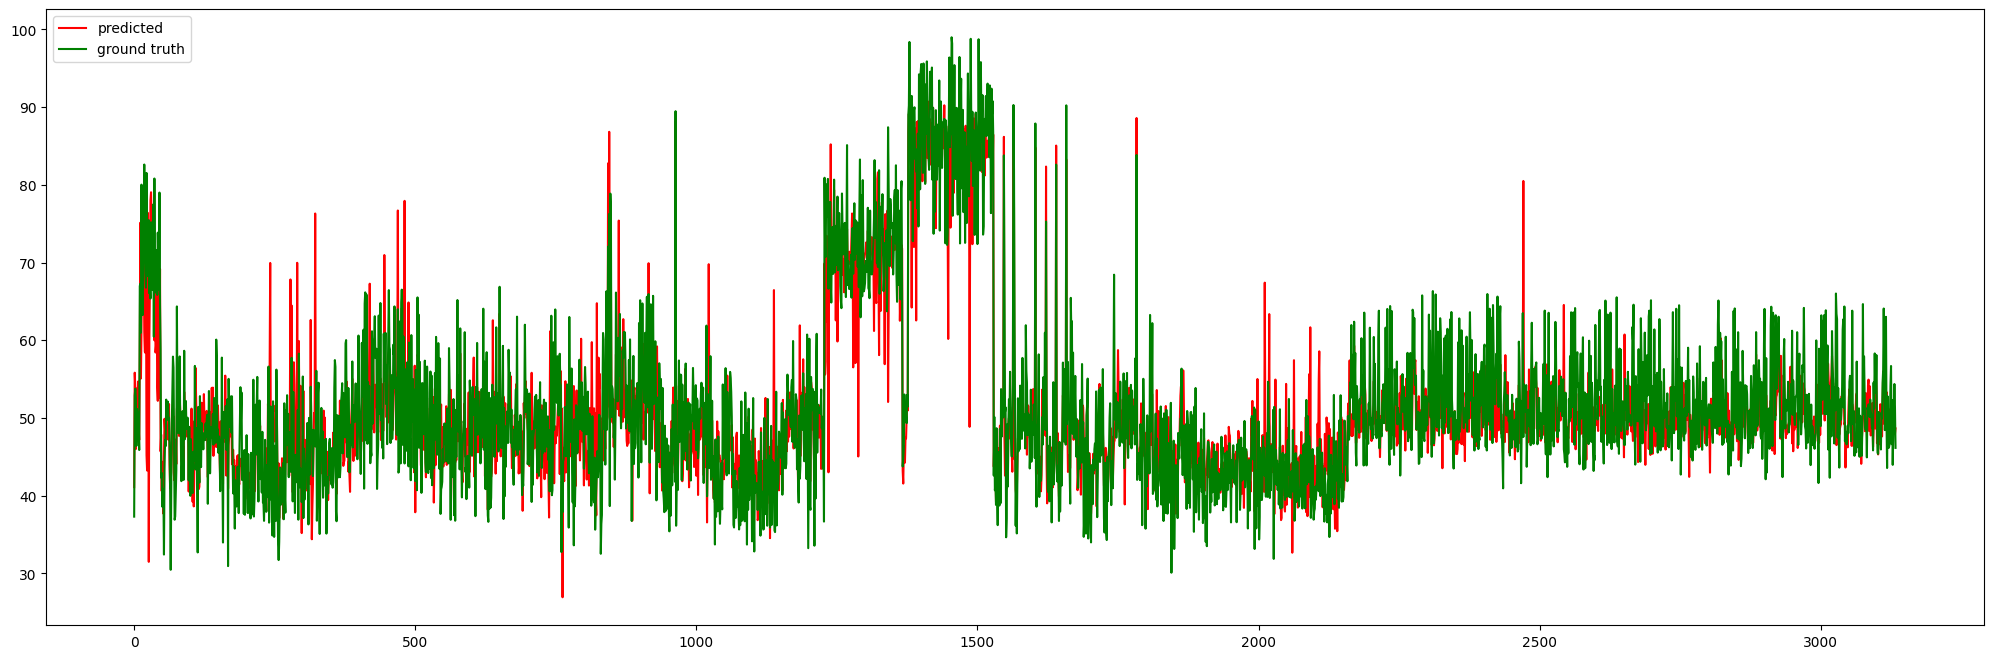

In [5]:
test_set, test_labels = test_loader.dataset.tensors
loss_test, outcome = Trainer.test_model(model, test_set, test_labels, loss, device)
from src.utilities import plot_results

plot_results( outcome, test_labels) 